In [1]:
cd ..

/home/scott/Documents/git/bite-me


In [2]:
import sklearn
import pandas as pd
import numpy as np
import datetime

In [3]:
import itertools
import copy

In [4]:
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [5]:
import sklearn.svm
import sklearn.linear_model
import sklearn.cross_validation

In [6]:
import sklearn.decomposition
import sklearn.manifold

In [7]:
from eat_it import StratifiedPercentileKFold
from eat_it import scalers
from eat_it import params

In [8]:
import imp

In [9]:
def do_cv(cv, clf, X, y, y_transform=None):
    if y_transform is None:
        y_transform = lambda x: x
    scores = []
    all_pred = np.zeros((y.shape))
    for train_index, test_index in cv:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit model
        clf.fit(X_train, y_train)
        # Predict scores for test data
        y_pred = y_transform(clf.predict(X_test))
        # Save all the predictions to an array
        all_pred[test_index] = y_pred
        # Compute mean squared error on this test set
        mse = sklearn.metrics.mean_squared_error(y_transform(y_test),y_pred)
        scores.append(mse)
    # Compute MSE across all samples
    all_score = sklearn.metrics.mean_squared_error(y_transform(y), all_pred)**0.5
    scores = np.asarray(scores)**0.5
    return all_score, scores

In [10]:
def get_cv_results(clf, X, y, n_folds=10, n_samp=25):
    all_scores = []
    for seed in range(n_samp):
        cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=n_folds, shuffle=True, random_state=seed, shuffle_windows=True)
        this_score, _ = do_cv(cv, clf, X=X, y=y)
        all_scores.append(this_score)
    return np.mean(all_scores), np.std(all_scores)/np.sqrt(n_folds)

def get_mean_cv_score(*args, **kwargs):
    out = get_cv_results(*args, **kwargs)
    return out[0]

In [52]:
### Recursive feature addition
from sklearn.base import clone

def rfa(clf, X, y, n_folds=10, n_samp=25, col_names=None, verbosity=2):
    
    n_features = X.shape[1]
    n_features_to_select = n_features
    step = 1
    
    if col_names is None:
        col_names = range(n_features)
    col_names = np.asarray(col_names)
    
    support_ = np.zeros(n_features, dtype=np.bool)
    ranking_ = n_features * np.ones(n_features, dtype=np.int)
    last_score = None
    
    # Feature addition
    while np.sum(support_) < n_features_to_select:
        # Previously added features
        features_already = np.arange(n_features)[support_]
        # Features to test
        features_to_test = np.arange(n_features)[np.logical_not(support_)]
        
        # Rank the remaining features
        estimator = clone(clf)
        
        #####################################
        # FIT THE CLASSIFIER ON A NESTED FOLD
        #####################################
        
        scores = np.zeros(len(features_to_test))
        for feature_index, test_feature in enumerate(features_to_test):
            features = np.union1d(features_already, [test_feature])
            scores[feature_index] = get_mean_cv_score(estimator, X[:, features], y, n_folds=n_folds, n_samp=n_samp)
            if verbosity>=2:
                print("\tScored %.2f with %s" % (scores[feature_index], ', '.join(col_names[features])))
        
        # Sort the scores in ascending order
        score_order_index = np.argsort(scores)
        ordered_scores   = scores[score_order_index]
        ordered_features = features_to_test[score_order_index]
        
        # Break if no features can improve score
        if last_score is not None and last_score <= ordered_scores[0]:
            if verbosity:
                print('No more improvement possible from {} to {} features'.format(
                        len(features_already),len(features_already)+1))
            break
        
        # Only add `step` many features if it doesn't take us past the target
        n_add = min(step, n_features_to_select - np.sum(support_))
        
        # Only add features which don't make performance go down
        if last_score is not None:
            n_add = min(n_add, len(np.nonzero(ordered_scores < last_score)))
        
        # Select best.
        # We will MINIMISE scoring function!!!
        features_to_add = ordered_features[0:n_add]
        for i in range(n_add):
            if verbosity:
                print('Adding feature {} (scored {})'.format(col_names[ordered_features[i]], ordered_scores[i]))
        
        # Add the features
        support_[features_to_add] = True
        ranking_[features_to_add] = np.sum(support_) + 1 + np.arange(features_to_add)
        
        # Update score monitor
        last_score = ordered_scores[0]
        
    if verbosity:
        print("Best score is {} with features:\n\t{}".format(last_score,', '.join(col_names[support_])))
    
    return support_, ranking_

In [12]:
train = pd.read_csv('data/train.csv', encoding="utf-8")
# Add age in days
end_dt = datetime.datetime.strptime('2015-1-1', "%Y-%m-%d")
train['Age'] = [(end_dt - datetime.datetime.strptime(open_dt, "%m/%d/%Y")).days for open_dt in train['Open Date']]
# add size as boolean field
train['isBig'] = train['City Group']=='Big Cities'
# add each of the big cities as boolean field
train['isIstanbul'] = train['City']=='İstanbul'
train['isAnkara'] = train['City']=='Ankara'
train['isIzmir'] = train['City']=='İzmir'
# add boolean field for type
train['isIL'] = train['Type']=='IL'
# Note when there is the missing 17 fields
train['missingSource'] = train[params.xor_cols].apply(lambda x: np.all(x==0), axis=1)

In [13]:
gtest = pd.read_csv('data/genuinetest.csv', encoding="utf-8")
# Add age in days
end_dt = datetime.datetime.strptime('2015-1-1', "%Y-%m-%d")
gtest['Age'] = [(end_dt - datetime.datetime.strptime(open_dt, "%m/%d/%Y")).days for open_dt in gtest['Open Date']]
# add size as boolean field
gtest['isBig'] = gtest['City Group']=='Big Cities'
# add each of the big cities as boolean field
gtest['isIstanbul'] = gtest['City']=='İstanbul'
gtest['isAnkara'] = gtest['City']=='Ankara'
gtest['isIzmir'] = gtest['City']=='İzmir'
# add boolean field for type
gtest['isIL'] = gtest['Type']=='IL'
# Note when there is the missing 17 fields
gtest['missingSource'] = gtest[params.xor_cols].apply(lambda x: np.all(x==0), axis=1)

In [14]:
# Merge Test and Train together, without having revenue for all entries
unlabelled_data = pd.concat((train, gtest), ignore_index=True)

In [15]:
# Remove DT type from the dataset
unlabelled_data = unlabelled_data[unlabelled_data['Type']!='DT']
unlabelled_data = unlabelled_data[unlabelled_data['Type']!='MB']

In [16]:
# Add known revenues from public test data
gtestrevenue = pd.read_csv('data/genuinetestrevenue.csv', encoding="utf-8")
labelled_test = pd.merge(gtest, gtestrevenue, on='Id')
# Merge all available training data together
data = pd.concat((train, labelled_test), ignore_index=True)

In [17]:
# Remove DT type from the list
data = data[data['Type']!='DT']
data = data[data['Type']!='MB']

In [18]:
# Assemble list of columns
Pcols = ['P'+str(i) for i in range(1,38)]
PMcols = params.xor_cols
PVcols = [i for i in Pcols if i not in params.xor_cols]
Gcols = ['Age']
Ocols = ['isBig','isIstanbul','isAnkara','isIzmir','isIL','missingSource']
cols = Pcols + Gcols + Ocols

In [19]:
# Targets
y = data['revenue'].values

In [20]:
X_indices = data['Id'].values

In [21]:
uX_indices = unlabelled_data['Id'].values

In [22]:
index_is_labelled = [i in X_indices for i in uX_indices]
index_is_labelled = np.asarray(index_is_labelled)

In [23]:
np.array_equal(uX_indices[index_is_labelled], X_indices)

True

In [24]:
unlabelled_data_nomissing = np.logical_not(unlabelled_data['missingSource'].values)
data_nomissing = np.logical_not(data['missingSource'].values)

In [25]:
# Other (already one-hot columns) can stay as they are
XO = data.as_matrix(Ocols).astype(np.float)

# Need to take logs because sometimes Age can't be mapped correctly by BoxCox
u = np.log(unlabelled_data.as_matrix(Gcols).astype(np.float))
d = np.log(data.as_matrix(Gcols).astype(np.float))
XG = scalers.BoxCoxScaler().fit(u).transform(d)

# Valid-always columns
u = unlabelled_data.as_matrix(PVcols).astype(np.float)
d = data.as_matrix(PVcols).astype(np.float)
s = scalers.BoxCoxScaler().fit(u)
XPV = s.transform(d)
uXPV = s.transform(u)

# Missing-sometimes columns
u = unlabelled_data.as_matrix(PMcols).astype(np.float)[unlabelled_data_nomissing]
d = data.as_matrix(PMcols).astype(np.float)
s = scalers.BoxCoxScaler(known_min=0).fit(u)
XPM = s.transform(d)
uXPM = s.transform(u)

# All columns
XPA = np.concatenate((XPV,XPM),axis=1)

In [26]:
# Make a nice iterator to use for grid search
n_folds = 10
n_samp = 25
cvlist = []
for seed in range(n_samp):
    cvlist.append(StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=n_folds, shuffle=True, random_state=1000+seed, shuffle_windows=True))
# Make it a list so it is reusable
cv25by10 = list(itertools.chain(*cvlist))

In [27]:
# Make a nice iterator to use for grid search
n_folds = 10
n_samp = 5
cvlist = []
for seed in range(n_samp):
    cvlist.append(StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=n_folds, shuffle=True, random_state=1000+seed, shuffle_windows=True))
# Make it a list so it is reusable
cv5by10 = list(itertools.chain(*cvlist))

In [28]:
# Make a nice iterator to use for grid search
n_folds = 10
n_samp = 1
cvlist = []
for seed in range(n_samp):
    cvlist.append(StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=n_folds, shuffle=True, random_state=1000+seed, shuffle_windows=True))
# Make it a list so it is reusable
cv1by10 = list(itertools.chain(*cvlist))

## break

In [29]:
import sklearn.metrics

In [30]:
scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

In [30]:
X_ = np.concatenate((XPV, XG, XO), axis=1)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

parameters = {'kernel':('linear', 'rbf'), 'C':[0.3, 1, 3, 10, 30, 100, 300, 1000, 100000]}
svr = sklearn.svm.SVR()
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv1by10)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

The best parameters are {'C': 100000, 'kernel': 'linear'} with a score of 2384698.38


In [37]:
X_ = np.concatenate((XPV, XG, XO), axis=1)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

parameters = {'kernel':('linear', 'rbf'), 'C':[1e0, 1e3, 1e4, 5e4, 6e4, 7e4, 1e5]}
svr = sklearn.svm.SVR()
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv1by10)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

The best parameters are {'C': 60000.0, 'kernel': 'linear'} with a score of 2383857.66


In [39]:
clf.grid_scores_

[mean: -6530960131384.50586, std: 4533215344353.94824, params: {'C': 1.0, 'kernel': 'linear'},
 mean: -6531004025966.71191, std: 4533308315611.16602, params: {'C': 1.0, 'kernel': 'rbf'},
 mean: -6392533161711.38965, std: 4426570850880.86035, params: {'C': 1000.0, 'kernel': 'linear'},
 mean: -6529143409491.83398, std: 4533382911043.43945, params: {'C': 1000.0, 'kernel': 'rbf'},
 mean: -5915245996058.17188, std: 4061034683890.93555, params: {'C': 10000.0, 'kernel': 'linear'},
 mean: -6512081643427.41406, std: 4529035182543.86035, params: {'C': 10000.0, 'kernel': 'rbf'},
 mean: -5772418270555.89453, std: 3908109826828.02539, params: {'C': 30000.0, 'kernel': 'linear'},
 mean: -6433797472798.80762, std: 4468224639060.06250, params: {'C': 30000.0, 'kernel': 'rbf'},
 mean: -5699214081829.04590, std: 3859005807475.50928, params: {'C': 50000.0, 'kernel': 'linear'},
 mean: -6379998669738.92383, std: 4432951076592.37598, params: {'C': 50000.0, 'kernel': 'rbf'},
 mean: -5682777337969.61914, std: 3

In [32]:
X_ = np.concatenate((XPV, XG, XO), axis=1)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

parameters = {'C':[1e0, 1e3, 1e4, 5e4, 6e4, 7e4, 1e5]}
svr = sklearn.svm.SVR(kernel='linear')
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv1by10)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

The best parameters are {'C': 60000.0} with a score of 2383857.66


[mean: -6530960131384.50586, std: 4533215344353.94824, params: {'C': 1.0},
 mean: -6392533161711.38965, std: 4426570850880.86035, params: {'C': 1000.0},
 mean: -5915245996058.17188, std: 4061034683890.93555, params: {'C': 10000.0},
 mean: -5699214081829.04590, std: 3859005807475.50928, params: {'C': 50000.0},
 mean: -5682777337969.61914, std: 3833475794862.65576, params: {'C': 60000.0},
 mean: -5689247166150.07715, std: 3837279829419.64258, params: {'C': 70000.0},
 mean: -5686786383166.53613, std: 3776826990787.96924, params: {'C': 100000.0}]

In [35]:
X_ = np.concatenate((XPV, XG, XO), axis=1)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

parameters = {'C':[1e0, 1e3, 1e4, 5e4, 6e4, 7e4, 1e5]}
svr = sklearn.svm.SVR(kernel='linear')
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv25by10)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

The best parameters are {'C': 70000.0} with a score of 2383133.48


[mean: -6530267659765.50781, std: 4401289130360.07910, params: {'C': 1.0},
 mean: -6390897528817.22656, std: 4361648102976.52637, params: {'C': 1000.0},
 mean: -5912201018317.94336, std: 4055362645514.04785, params: {'C': 10000.0},
 mean: -5709037163329.89844, std: 3882702956791.79346, params: {'C': 50000.0},
 mean: -5687659023151.10449, std: 3848797922888.48633, params: {'C': 60000.0},
 mean: -5679325202975.77441, std: 3826379458404.96143, params: {'C': 70000.0},
 mean: -5691277301681.13379, std: 3786035678607.43115, params: {'C': 100000.0}]

In [39]:
X_ = np.concatenate((XPV, XG, XO), axis=1)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

parameters = {'C':[1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 5e5, 1e6, 2e6, 1e7, 1e8]}
svr = sklearn.svm.SVR(kernel='rbf')
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv5by10)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

The best parameters are {'C': 2000000.0} with a score of 2418572.06


[mean: -6529973404919.24023, std: 4479768026736.38867, params: {'C': 1.0},
 mean: -6529956147190.73828, std: 4479769695083.59863, params: {'C': 10.0},
 mean: -6529783833432.26660, std: 4479786395229.10645, params: {'C': 100.0},
 mean: -6528087048499.66602, std: 4479955065977.67969, params: {'C': 1000.0},
 mean: -6512950691768.01660, std: 4481546038199.06934, params: {'C': 10000.0},
 mean: -6298951986980.91211, std: 4389260025512.38232, params: {'C': 100000.0},
 mean: -5934155685688.15625, std: 4120791458341.72900, params: {'C': 500000.0},
 mean: -5893445198120.73828, std: 3978382374978.63330, params: {'C': 1000000.0},
 mean: -5849490826426.58398, std: 3734392649045.84814, params: {'C': 2000000.0},
 mean: -6178211731741.51074, std: 3233870642497.74121, params: {'C': 10000000.0},
 mean: -8830120989656.75977, std: 5545478915780.09473, params: {'C': 100000000.0}]

In [41]:
X_ = np.concatenate((XPV, XG, XO), axis=1)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

parameters = {'C':[9e5, 1e6, 2e6, 3e6, 4e6, 5e6]}
svr = sklearn.svm.SVR(kernel='rbf')
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv25by10)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

The best parameters are {'C': 3000000.0} with a score of 2396692.46


[mean: -5858798481356.11230, std: 3915132035624.86426, params: {'C': 900000.0},
 mean: -5848795434894.12695, std: 3886956379553.28711, params: {'C': 1000000.0},
 mean: -5772670731770.06836, std: 3659945825775.68604, params: {'C': 2000000.0},
 mean: -5744134724261.12207, std: 3550800930659.63965, params: {'C': 3000000.0},
 mean: -5746160671745.72949, std: 3501359347642.68604, params: {'C': 4000000.0},
 mean: -5779804613724.85156, std: 3460735436171.83447, params: {'C': 5000000.0}]

In [43]:
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

cc = ['P3', 'P6', 'P8', 'P21', 'Age', 'isIstanbul', 'isIzmir', 'isIL']
li = np.array([c in cc for c in cols_])
X_ = X_[:,li]

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

parameters = {'C':[1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]}
svr = sklearn.svm.SVR(kernel='rbf')
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv25by10)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
The best parameters are {'C': 1000000.0} with a score of 2410446.09


[mean: -6530281779695.08398, std: 4401198633021.82520, params: {'C': 1.0},
 mean: -6530236085000.18652, std: 4401175973533.74902, params: {'C': 10.0},
 mean: -6529779698440.83984, std: 4400949417470.89062, params: {'C': 100.0},
 mean: -6525271871806.15723, std: 4398687746895.27051, params: {'C': 1000.0},
 mean: -6483400683228.40820, std: 4376001714536.39307, params: {'C': 10000.0},
 mean: -6191558781991.14746, std: 4204359010962.41260, params: {'C': 100000.0},
 mean: -5810250359444.14844, std: 3665298067673.55225, params: {'C': 1000000.0},
 mean: -6204791524049.57031, std: 3278375389750.27832, params: {'C': 10000000.0},
 mean: -9570990847618.42383, std: 4742333588348.27734, params: {'C': 100000000.0}]

In [45]:
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

cc = ['P3', 'Age', 'isIstanbul', 'isIzmir', 'isIL']
li = np.array([c in cc for c in cols_])
X_ = X_[:,li]

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

parameters = {'C':[1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]}
svr = sklearn.svm.SVR(kernel='rbf')
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv25by10)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
The best parameters are {'C': 1000000.0} with a score of 2416265.94


[mean: -6530280955281.76758, std: 4401197285594.81250, params: {'C': 1.0},
 mean: -6530227841933.44629, std: 4401162499462.34766, params: {'C': 10.0},
 mean: -6529697374411.57910, std: 4400814696641.22559, params: {'C': 100.0},
 mean: -6524459295328.94824, std: 4397342538926.32910, params: {'C': 1000.0},
 mean: -6477002386926.22461, std: 4363839942651.79736, params: {'C': 10000.0},
 mean: -6188101846919.67188, std: 4159171699320.05811, params: {'C': 100000.0},
 mean: -5838341109926.57227, std: 3691565802458.20312, params: {'C': 1000000.0},
 mean: -5981847596474.36035, std: 3121523181394.60938, params: {'C': 10000000.0},
 mean: -7004876955607.13281, std: 3198448042205.01807, params: {'C': 100000000.0}]

In [65]:
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

cc = ['P3', 'P6', 'P8', 'P21', 'Age', 'isIstanbul', 'isIzmir', 'isIL']
li = np.array([c in cc for c in cols_])
X_ = X_[:,li]

print(cc)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

C_range = [1e7, 1e8, 1e9, 1e10, 1e11]
gamma_range = [0, 0.0001, 0.001, 0.01, 0.1]
degree_range = [0.1, 0.5, 1]

C_range = [1e9, 1e10]
gamma_range = [0, 0.0001, 0.001, 0.01]
degree_range = [0.1, 0.5]

parameters = dict(gamma=gamma_range, C=C_range, degree=degree_range)

svr = sklearn.svm.SVR(kernel='rbf')
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv1by10, n_jobs=4)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
['P3', 'P6', 'P8', 'P21', 'Age', 'isIstanbul', 'isIzmir', 'isIL']
The best parameters are {'degree': 0.1, 'gamma': 0.0001, 'C': 10000000000.0} with a score of 2303279.88


[mean: -14942866041667.32227, std: 8227558716138.70312, params: {'degree': 0.1, 'gamma': 0, 'C': 1000000000.0},
 mean: -5407988133448.06738, std: 3632787475337.39697, params: {'degree': 0.1, 'gamma': 0.0001, 'C': 1000000000.0},
 mean: -5364399912087.05664, std: 3699173327489.53467, params: {'degree': 0.1, 'gamma': 0.001, 'C': 1000000000.0},
 mean: -6364453720951.48047, std: 3185987240892.93066, params: {'degree': 0.1, 'gamma': 0.01, 'C': 1000000000.0},
 mean: -14942866041667.32227, std: 8227558716138.70312, params: {'degree': 0.5, 'gamma': 0, 'C': 1000000000.0},
 mean: -5407988133448.06738, std: 3632787475337.39697, params: {'degree': 0.5, 'gamma': 0.0001, 'C': 1000000000.0},
 mean: -5364399912087.05664, std: 3699173327489.53467, params: {'degree': 0.5, 'gamma': 0.001, 'C': 1000000000.0},
 mean: -6364453720951.48047, std: 3185987240892.93066, params: {'degree': 0.5, 'gamma': 0.01, 'C': 1000000000.0},
 mean: -43406883169821.07812, std: 23421700818216.44141, params: {'degree': 0.1, 'gamm

In [69]:
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

cc = ['P3', 'P6', 'P8', 'P21', 'Age', 'isIstanbul', 'isIzmir', 'isIL']
li = np.array([c in cc for c in cols_])
X_ = X_[:,li]

print(cc)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

C_range = [1e10, 1e11, 1e12]
gamma_range = [1e-5, 1e-4, 1e-3]
degree_range = [1e-4, 1e-3, 1e-2, 1e-1]

parameters = dict(gamma=gamma_range, C=C_range, degree=degree_range)

svr = sklearn.svm.SVR(kernel='rbf')
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv1by10, n_jobs=6)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
['P3', 'P6', 'P8', 'P21', 'Age', 'isIstanbul', 'isIzmir', 'isIL']
The best parameters are {'degree': 0.0001, 'gamma': 0.0001, 'C': 10000000000.0} with a score of 2303279.88


[mean: -5400763569261.48828, std: 3625604848837.72852, params: {'degree': 0.0001, 'gamma': 1e-05, 'C': 10000000000.0},
 mean: -5305098199686.57910, std: 3606423086008.66113, params: {'degree': 0.0001, 'gamma': 0.0001, 'C': 10000000000.0},
 mean: -5532241669921.08887, std: 3446021736973.08838, params: {'degree': 0.0001, 'gamma': 0.001, 'C': 10000000000.0},
 mean: -5400763569261.48828, std: 3625604848837.72852, params: {'degree': 0.001, 'gamma': 1e-05, 'C': 10000000000.0},
 mean: -5305098199686.57910, std: 3606423086008.66113, params: {'degree': 0.001, 'gamma': 0.0001, 'C': 10000000000.0},
 mean: -5532241669921.08887, std: 3446021736973.08838, params: {'degree': 0.001, 'gamma': 0.001, 'C': 10000000000.0},
 mean: -5400763569261.48828, std: 3625604848837.72852, params: {'degree': 0.01, 'gamma': 1e-05, 'C': 10000000000.0},
 mean: -5305098199686.57910, std: 3606423086008.66113, params: {'degree': 0.01, 'gamma': 0.0001, 'C': 10000000000.0},
 mean: -5532241669921.08887, std: 3446021736973.0883

In [78]:
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

cc = ['P3', 'P6', 'P8', 'P21', 'Age', 'isIstanbul', 'isIzmir', 'isIL']
li = np.array([c in cc for c in cols_])
X_ = X_[:,li]

print(cc)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

C_range = [1e9, 1e10]
gamma_range = [1e-5, 1e-4, 1e-3]
degree_range = [0, 1e-18]

parameters = dict(gamma=gamma_range, C=C_range, degree=degree_range)

svr = sklearn.svm.SVR(kernel='rbf')
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv1by10, n_jobs=6)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
['P3', 'P6', 'P8', 'P21', 'Age', 'isIstanbul', 'isIzmir', 'isIL']
The best parameters are {'degree': 0, 'gamma': 0.0001, 'C': 10000000000.0} with a score of 2303279.88


[mean: -5836651911218.41211, std: 4028469934689.38916, params: {'degree': 0, 'gamma': 1e-05, 'C': 1000000000.0},
 mean: -5407988133448.06738, std: 3632787475337.39697, params: {'degree': 0, 'gamma': 0.0001, 'C': 1000000000.0},
 mean: -5364399912087.05664, std: 3699173327489.53467, params: {'degree': 0, 'gamma': 0.001, 'C': 1000000000.0},
 mean: -5836651911218.41211, std: 4028469934689.38916, params: {'degree': 1e-18, 'gamma': 1e-05, 'C': 1000000000.0},
 mean: -5407988133448.06738, std: 3632787475337.39697, params: {'degree': 1e-18, 'gamma': 0.0001, 'C': 1000000000.0},
 mean: -5364399912087.05664, std: 3699173327489.53467, params: {'degree': 1e-18, 'gamma': 0.001, 'C': 1000000000.0},
 mean: -5400763569261.48828, std: 3625604848837.72852, params: {'degree': 0, 'gamma': 1e-05, 'C': 10000000000.0},
 mean: -5305098199686.57910, std: 3606423086008.66113, params: {'degree': 0, 'gamma': 0.0001, 'C': 10000000000.0},
 mean: -5532241669921.08887, std: 3446021736973.08838, params: {'degree': 0, 'g

In [80]:
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

C_range = [1e9, 1e10]
gamma_range = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
degree_range = [0, 1e-18, 1e-15]

parameters = dict(gamma=gamma_range, C=C_range, degree=degree_range)

svr = sklearn.svm.SVR(kernel='rbf')
clf = sklearn.grid_search.GridSearchCV(svr, parameters, scoring=scorer, cv=cv1by10, n_jobs=6)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
The best parameters are {'degree': 0, 'gamma': 1e-05, 'C': 10000000000.0} with a score of 2407661.83


[mean: -6518774409559.99707, std: 4517119090911.91699, params: {'degree': 0, 'gamma': 1e-07, 'C': 1000000000.0},
 mean: -6317514186360.21582, std: 4352105629510.74023, params: {'degree': 0, 'gamma': 1e-06, 'C': 1000000000.0},
 mean: -5809938798363.81836, std: 3965676446873.14111, params: {'degree': 0, 'gamma': 1e-05, 'C': 1000000000.0},
 mean: -5800260976997.81836, std: 3709439812205.82373, params: {'degree': 0, 'gamma': 0.0001, 'C': 1000000000.0},
 mean: -6321866041234.45215, std: 3479686765888.78369, params: {'degree': 0, 'gamma': 0.001, 'C': 1000000000.0},
 mean: -6518774409559.99707, std: 4517119090911.91699, params: {'degree': 1e-18, 'gamma': 1e-07, 'C': 1000000000.0},
 mean: -6317514186360.21582, std: 4352105629510.74023, params: {'degree': 1e-18, 'gamma': 1e-06, 'C': 1000000000.0},
 mean: -5809938798363.81836, std: 3965676446873.14111, params: {'degree': 1e-18, 'gamma': 1e-05, 'C': 1000000000.0},
 mean: -5800260976997.81836, std: 3709439812205.82373, params: {'degree': 1e-18, 'g

In [74]:
10000000000==1e10

True

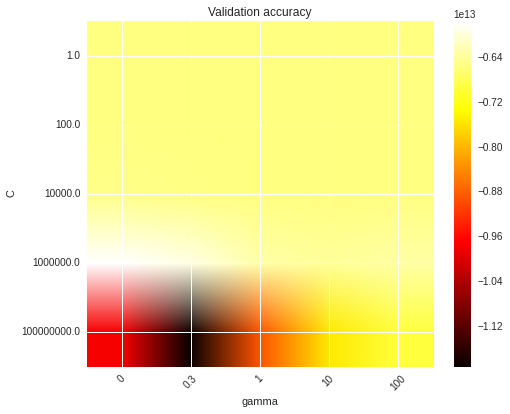

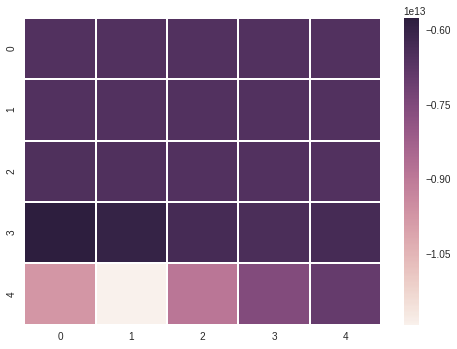

In [59]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

sns.heatmap(scores)

In [ ]:
X_ = np.concatenate((XPV, XG, XO), axis=1)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

svr = sklearn.svm.SVR(kernel='linear')
clf = sklearn.grid_search.GridSearchCV(svr, param_grid=param_grid, cv=cv1by10)
clf.fit(X_, y)

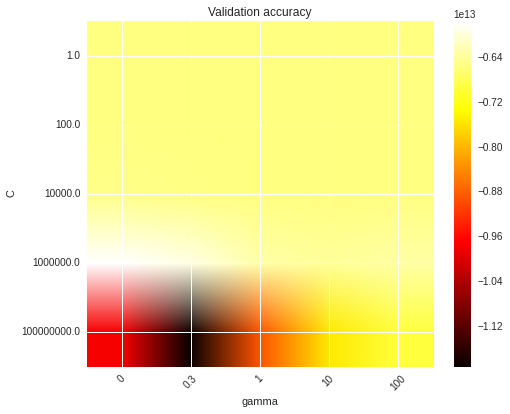

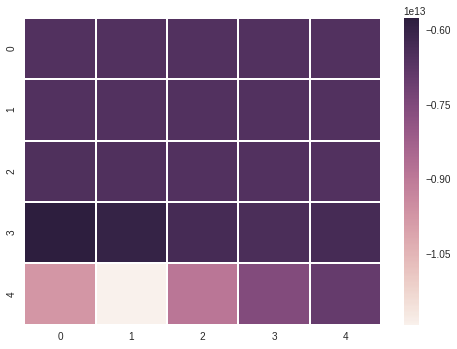

In [59]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

sns.heatmap(scores)

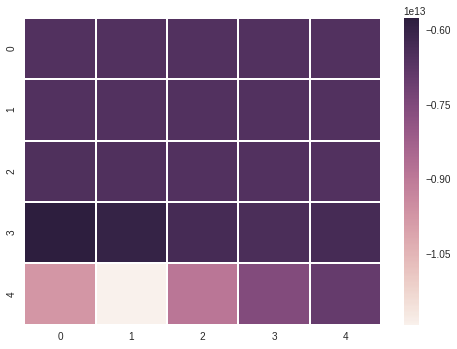

## Testing without RFA

```
2440899 Linear Regression, BoxCox, no dim reduction
2440893 Lasso (defaults)
2290192 ElasticNet (defaults)
2415462 Ridge
2555417 SVR linear
2379866 SVR linear, fit C
2382113 SVR rbf, fit degrees, gamma, C
```

In [31]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.LinearRegression()
mu, st = get_cv_results(clf, X_, y)
print('{}+/-{}'.format(mu, st))

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
2440899.2759846514+/-13251.84986648349


In [34]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Lasso(max_iter=100000)
mu, st = get_cv_results(clf, X_, y)
print('{}+/-{}'.format(mu, st))

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
2440893.84258803+/-13251.40605910222


In [35]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNet(max_iter=100000)
mu, st = get_cv_results(clf, X_, y)
print('{}+/-{}'.format(mu, st))

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
2290192.724398682+/-3305.024270276368


In [36]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Ridge(max_iter=100000)
mu, st = get_cv_results(clf, X_, y)
print('{}+/-{}'.format(mu, st))

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
2415462.607377687+/-11570.091257313321


In [53]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.svm.SVR(kernel='linear')
mu, st = get_cv_results(clf, X_, y)
print('{}+/-{}'.format(mu, st))

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
2555417.9247550447+/-159.17697585027804


In [84]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.svm.SVR(kernel='linear', C=7e4)
mu, st = get_cv_results(clf, X_, y)
print('{}+/-{}'.format(mu, st))

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
2379866.568843327+/-4572.515107105542


In [54]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.svm.SVR(kernel='rbf')
mu, st = get_cv_results(clf, X_, y)
print('{}+/-{}'.format(mu, st))

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
2555420.144306766+/-160.30396540489946


In [85]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.svm.SVR(kernel='rbf', degree=0, gamma=1e-05, C=1e10)
mu, st = get_cv_results(clf, X_, y)
print('{}+/-{}'.format(mu, st))

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
2382113.702861568+/-7186.728102680357


##Model testing

```
2252608 Linear Regression, BoxCox, no dim reduction
2252608 Lasso (defaults)
2238888 ElasticNet (defaults)
2248317 Ridge
2555387 SVR linear
2329017 SVR linear, pre-fit
2287457 SVR rbf, pre-fit
```

In [25]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.LinearRegression()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2493732.01 with P1
	Scored 2459416.38 with P2
	Scored 2520706.61 with P3
	Scored 2517811.21 with P4
	Scored 2523291.01 with P5
	Scored 2465658.88 with P6
	Scored 2509270.26 with P7
	Scored 2501593.64 with P8
	Scored 2515763.43 with P9
	Scored 2513615.62 with P10
	Scored 2498818.87 with P11
	Scored 2517826.33 with P12
	Scored 2515057.24 with P13
	Scored 2530112.22 with P19
	Scored 2504939.59 with P20
	Scored 2489600.74 with P21
	Scored 2522997.78 with P22
	Scored 2523945.42 with P23
	Scored 2443137.71 with P28
	Scored 2487549.87 with P29
	Scored 2383265.17 with Age
	Scored 2421061.88 with isBig
	Scored 2406686.31 with isIstanbul
	Scored 2524844.04 with isAnkara
	Scored 2531819.78 with isIzmir
	Scored 2509921.33 with isIL
	Scored 2524877.55 with missingSource
Adding feature

In [26]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Lasso()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2493732.01 with P1
	Scored 2459416.38 with P2
	Scored 2520706.47 with P3
	Scored 2517811.19 with P4
	Scored 2523290.85 with P5
	Scored 2465658.87 with P6
	Scored 2509270.26 with P7
	Scored 2501593.64 with P8
	Scored 2515763.43 with P9
	Scored 2513615.62 with P10
	Scored 2498818.87 with P11
	Scored 2517826.32 with P12
	Scored 2515057.23 with P13
	Scored 2530112.14 with P19
	Scored 2504939.59 with P20
	Scored 2489600.74 with P21
	Scored 2522997.78 with P22
	Scored 2523945.38 with P23
	Scored 2443137.70 with P28
	Scored 2487549.88 with P29
	Scored 2383265.16 with Age
	Scored 2421061.87 with isBig
	Scored 2406686.30 with isIstanbul
	Scored 2524844.03 with isAnkara
	Scored 2531819.49 with isIzmir
	Scored 2509921.33 with isIL
	Scored 2524877.18 with missingSource
Adding feature

In [27]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNet()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2493350.58 with P1
	Scored 2462283.70 with P2
	Scored 2517735.01 with P3
	Scored 2514979.24 with P4
	Scored 2519226.37 with P5
	Scored 2466855.99 with P6
	Scored 2508218.04 with P7
	Scored 2499277.94 with P8
	Scored 2512244.42 with P9
	Scored 2508579.48 with P10
	Scored 2497809.03 with P11
	Scored 2513412.71 with P12
	Scored 2510449.85 with P13
	Scored 2523753.19 with P19
	Scored 2503847.87 with P20
	Scored 2487505.42 with P21
	Scored 2516272.72 with P22
	Scored 2519224.96 with P23
	Scored 2446937.79 with P28
	Scored 2482968.83 with P29
	Scored 2392115.41 with Age
	Scored 2459388.95 with isBig
	Scored 2451872.25 with isIstanbul
	Scored 2512917.56 with isAnkara
	Scored 2512903.61 with isIzmir
	Scored 2507569.74 with isIL
	Scored 2515562.38 with missingSource
Adding feature

In [28]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNetCV()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2511538.15 with P1
	Scored 2511460.92 with P2
	Scored 2511762.47 with P3
	Scored 2511707.71 with P4
	Scored 2511714.79 with P5
	Scored 2511454.31 with P6
	Scored 2511605.90 with P7
	Scored 2511555.60 with P8
	Scored 2511713.66 with P9
	Scored 2511630.17 with P10
	Scored 2511555.59 with P11
	Scored 2511725.38 with P12
	Scored 2511639.45 with P13
	Scored 2511739.84 with P19
	Scored 2511602.17 with P20
	Scored 2511508.48 with P21
	Scored 2511727.27 with P22
	Scored 2511733.67 with P23
	Scored 2511427.94 with P28
	Scored 2511471.42 with P29
	Scored 2511333.43 with Age
	Scored 2511545.60 with isBig
	Scored 2511536.65 with isIstanbul
	Scored 2511704.04 with isAnkara
	Scored 2511693.17 with isIzmir
	Scored 2511646.10 with isIL
	Scored 2511707.12 with missingSource
Adding feature

KeyboardInterrupt: 

In [29]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Ridge()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2493665.24 with P1
	Scored 2459343.83 with P2
	Scored 2520647.68 with P3
	Scored 2517745.99 with P4
	Scored 2523207.88 with P5
	Scored 2465578.23 with P6
	Scored 2509231.15 with P7
	Scored 2501499.35 with P8
	Scored 2515673.40 with P9
	Scored 2513481.01 with P10
	Scored 2498740.83 with P11
	Scored 2517720.55 with P12
	Scored 2514935.86 with P13
	Scored 2529983.63 with P19
	Scored 2504887.79 with P20
	Scored 2489471.42 with P21
	Scored 2522830.37 with P22
	Scored 2523845.58 with P23
	Scored 2443038.71 with P28
	Scored 2487328.41 with P29
	Scored 2383160.10 with Age
	Scored 2420836.57 with isBig
	Scored 2406048.40 with isIstanbul
	Scored 2523649.32 with isAnkara
	Scored 2528624.22 with isIzmir
	Scored 2509550.28 with isIL
	Scored 2524467.19 with missingSource
Adding feature

In [30]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.BayesianRidge()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2511685.11 with P1
	Scored 2511685.11 with P2
	Scored 2511685.11 with P3
	Scored 2511685.11 with P4
	Scored 2511685.11 with P5
	Scored 2511685.11 with P6
	Scored 2511685.11 with P7
	Scored 2511685.11 with P8
	Scored 2511685.11 with P9
	Scored 2511685.11 with P10
	Scored 2511685.11 with P11
	Scored 2511685.11 with P12
	Scored 2511685.11 with P13
	Scored 2511685.11 with P19
	Scored 2511685.11 with P20
	Scored 2511685.11 with P21
	Scored 2511685.11 with P22
	Scored 2511685.11 with P23
	Scored 2511685.11 with P28
	Scored 2511685.11 with P29
	Scored 2511685.11 with Age
	Scored 2511685.11 with isBig
	Scored 2511685.11 with isIstanbul
	Scored 2511685.11 with isAnkara
	Scored 2511685.11 with isIzmir
	Scored 2511685.11 with isIL
	Scored 2511685.11 with missingSource
Adding feature

In [52]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.svm.SVR(kernel='linear')
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2555421.62 with P1
	Scored 2555417.53 with P2
	Scored 2555424.21 with P3
	Scored 2555421.17 with P4
	Scored 2555420.69 with P5
	Scored 2555414.53 with P6
	Scored 2555422.14 with P7
	Scored 2555419.63 with P8
	Scored 2555422.16 with P9
	Scored 2555423.30 with P10
	Scored 2555416.73 with P11
	Scored 2555420.97 with P12
	Scored 2555422.90 with P13
	Scored 2555423.22 with P19
	Scored 2555423.26 with P20
	Scored 2555421.74 with P21
	Scored 2555423.56 with P22
	Scored 2555425.94 with P23
	Scored 2555418.57 with P28
	Scored 2555420.88 with P29
	Scored 2555411.99 with Age
	Scored 2555416.94 with isBig
	Scored 2555416.10 with isIstanbul
	Scored 2555420.61 with isAnkara
	Scored 2555420.54 with isIzmir
	Scored 2555420.63 with isIL
	Scored 2555420.18 with missingSource
Adding feature

In [86]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.svm.SVR(kernel='linear', C=7e4)
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2544421.05 with P1
	Scored 2521302.46 with P2
	Scored 2567428.18 with P3
	Scored 2552804.30 with P4
	Scored 2559298.85 with P5
	Scored 2516690.58 with P6
	Scored 2560620.75 with P7
	Scored 2550684.86 with P8
	Scored 2567636.02 with P9
	Scored 2572372.52 with P10
	Scored 2542917.39 with P11
	Scored 2565176.84 with P12
	Scored 2572256.50 with P13
	Scored 2573354.83 with P19
	Scored 2558908.45 with P20
	Scored 2565907.62 with P21
	Scored 2577489.84 with P22
	Scored 2573679.53 with P23
	Scored 2508368.29 with P28
	Scored 2561619.86 with P29
	Scored 2473139.43 with Age
	Scored 2505739.35 with isBig
	Scored 2482682.61 with isIstanbul
	Scored 2558205.15 with isAnkara
	Scored 2556032.37 with isIzmir
	Scored 2562211.76 with isIL
	Scored 2571433.53 with missingSource
Adding feature

In [87]:
# Only valid columns, and no dimensionality reduction
X_ = np.concatenate((XPV, XG, XO), axis=1)
cols_ = PVcols + Gcols + Ocols

print(cols_)

clf = sklearn.svm.SVR(kernel='rbf', degree=0, gamma=1e-05, C=1e10)
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2546843.26 with P1
	Scored 2515881.17 with P2
	Scored 2567937.41 with P3
	Scored 2553651.82 with P4
	Scored 2560100.21 with P5
	Scored 2518674.38 with P6
	Scored 2560337.09 with P7
	Scored 2550393.11 with P8
	Scored 2568574.00 with P9
	Scored 2573148.61 with P10
	Scored 2542372.03 with P11
	Scored 2566367.27 with P12
	Scored 2572793.25 with P13
	Scored 2574063.71 with P19
	Scored 2559553.42 with P20
	Scored 2565572.82 with P21
	Scored 2578448.57 with P22
	Scored 2578747.42 with P23
	Scored 2507803.23 with P28
	Scored 2562324.34 with P29
	Scored 2466739.56 with Age
	Scored 2491381.38 with isBig
	Scored 2462176.81 with isIstanbul
	Scored 2555791.59 with isAnkara
	Scored 2556868.20 with isIzmir
	Scored 2568077.70 with isIL
	Scored 2574736.57 with missingSource
Adding feature

## With ICA

```
2203535 Linear Regression, BoxCox, no dim reduction
2203535 Lasso (defaults)
2321395 ElasticNet (defaults)
2239975 Ridge
```

In [38]:
# ICA on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.FastICA(random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
PVcols_ = ['PV_ICA_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.LinearRegression()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2513823.97 with PV_ICA_0
	Scored 2464974.36 with PV_ICA_1
	Scored 2531027.67 with PV_ICA_2
	Scored 2514027.80 with PV_ICA_3
	Scored 2535031.96 with PV_ICA_4
	Scored 2521038.48 with PV_ICA_5
	Scored 2507575.70 with PV_ICA_6
	Scored 2455797.14 with PV_ICA_7
	Scored 2529881.71 with PV_ICA_8
	Scored 2530442.01 with PV_ICA_9
	Scored 2467955.42 with PV_ICA_10
	Scored 2516070.59 with PV_ICA_11
	Scored 2512068.48 with PV_ICA_12
	Scored 2523766.24 with PV_ICA_13
	Scored 2514603.44 with PV_ICA_14
	Scored 2523149.37 with PV_ICA_15
	Scored 2525053.49 with PV_ICA_16
	Scored 2518291.51 with PV_ICA_17
	Scored 2493577.21 with PV_ICA_18
	Scored 2515258.89 with PV_ICA_19
	

/usr/local/lib/python3.4/dist-packages/sklearn/decomposition/fastica_.py:110: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


In [39]:
# ICA on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.FastICA(random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
PVcols_ = ['PV_ICA_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Lasso()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2513823.99 with PV_ICA_0
	Scored 2464974.24 with PV_ICA_1
	Scored 2531023.55 with PV_ICA_2
	Scored 2514027.77 with PV_ICA_3
	Scored 2535028.18 with PV_ICA_4
	Scored 2521035.86 with PV_ICA_5
	Scored 2507575.70 with PV_ICA_6
	Scored 2455797.01 with PV_ICA_7
	Scored 2529877.95 with PV_ICA_8
	Scored 2530438.59 with PV_ICA_9
	Scored 2467955.58 with PV_ICA_10
	Scored 2516070.58 with PV_ICA_11
	Scored 2512068.20 with PV_ICA_12
	Scored 2523766.15 with PV_ICA_13
	Scored 2514601.23 with PV_ICA_14
	Scored 2523147.01 with PV_ICA_15
	Scored 2525053.00 with PV_ICA_16
	Scored 2518291.44 with PV_ICA_17
	Scored 2493577.00 with PV_ICA_18
	Scored 2515259.09 with PV_ICA_19
	

/usr/local/lib/python3.4/dist-packages/sklearn/decomposition/fastica_.py:110: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


In [40]:
# ICA on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.FastICA(random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
PVcols_ = ['PV_ICA_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNet()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2511658.13 with PV_ICA_0
	Scored 2511212.17 with PV_ICA_1
	Scored 2511770.57 with PV_ICA_2
	Scored 2511670.96 with PV_ICA_3
	Scored 2511780.36 with PV_ICA_4
	Scored 2511728.39 with PV_ICA_5
	Scored 2511595.90 with PV_ICA_6
	Scored 2511161.69 with PV_ICA_7
	Scored 2511749.73 with PV_ICA_8
	Scored 2511762.32 with PV_ICA_9
	Scored 2511143.87 with PV_ICA_10
	Scored 2511667.21 with PV_ICA_11
	Scored 2511616.82 with PV_ICA_12
	Scored 2511591.34 with PV_ICA_13
	Scored 2511692.45 with PV_ICA_14
	Scored 2511725.35 with PV_ICA_15
	Scored 2511709.79 with PV_ICA_16
	Scored 2511688.74 with PV_ICA_17
	Scored 2511551.14 with PV_ICA_18
	Scored 2511522.90 with PV_ICA_19
	

/usr/local/lib/python3.4/dist-packages/sklearn/decomposition/fastica_.py:110: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


In [41]:
# ICA on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.FastICA(random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
PVcols_ = ['PV_ICA_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Ridge()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2510551.21 with PV_ICA_0
	Scored 2488802.48 with PV_ICA_1
	Scored 2516476.84 with PV_ICA_2
	Scored 2511317.02 with PV_ICA_3
	Scored 2517159.95 with PV_ICA_4
	Scored 2514097.38 with PV_ICA_5
	Scored 2507420.02 with PV_ICA_6
	Scored 2485646.14 with PV_ICA_7
	Scored 2515513.01 with PV_ICA_8
	Scored 2516114.84 with PV_ICA_9
	Scored 2486063.54 with PV_ICA_10
	Scored 2511301.83 with PV_ICA_11
	Scored 2508615.59 with PV_ICA_12
	Scored 2508710.86 with PV_ICA_13
	Scored 2512134.93 with PV_ICA_14
	Scored 2514078.22 with PV_ICA_15
	Scored 2513369.86 with PV_ICA_16
	Scored 2512137.23 with PV_ICA_17
	Scored 2504436.22 with PV_ICA_18
	Scored 2505259.61 with PV_ICA_19
	

/usr/local/lib/python3.4/dist-packages/sklearn/decomposition/fastica_.py:110: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


## With NMF

```
2202784 LinearRegression
2202783 Lasso
2301131 ElasticNet
2222863 ElasticNet with alpha=0.25, l1_ratio=0.72
2189961 Ridge
2358725 SVR linear (pre-fit)
2292844 SVR rbf (pre-fit)
```

In [88]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.LinearRegression()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2433928.43 with PV_NMF_0
	Scored 2461412.96 with PV_NMF_1
	Scored 2506833.49 with PV_NMF_2
	Scored 2483497.69 with PV_NMF_3
	Scored 2507868.12 with PV_NMF_4
	Scored 2492785.65 with PV_NMF_5
	Scored 2444939.00 with PV_NMF_6
	Scored 2512296.62 with PV_NMF_7
	Scored 2493308.76 with PV_NMF_8
	Scored 2515890.57 with PV_NMF_9
	Scored 2460003.66 with PV_NMF_10
	Scored 2465379.94 with PV_NMF_11
	Scored 2529380.03 with PV_NMF_12
	Scored 2532284.86 with PV_NMF_13
	Scored 2469169.37 with PV_NMF_14
	Scored 2501296.71 with PV_NMF_15
	Scored 2513968.79 with PV_NMF_16
	Scored 2520075.73 with PV_NMF_17
	Scored 2522855.41 with PV_NMF_18
	Scored 2498615.78 with PV_NMF_19
	

In [89]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Lasso()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2433928.39 with PV_NMF_0
	Scored 2461412.98 with PV_NMF_1
	Scored 2506833.50 with PV_NMF_2
	Scored 2483497.31 with PV_NMF_3
	Scored 2507868.10 with PV_NMF_4
	Scored 2492785.74 with PV_NMF_5
	Scored 2444939.00 with PV_NMF_6
	Scored 2512296.64 with PV_NMF_7
	Scored 2493308.74 with PV_NMF_8
	Scored 2515890.56 with PV_NMF_9
	Scored 2460003.64 with PV_NMF_10
	Scored 2465379.92 with PV_NMF_11
	Scored 2529378.58 with PV_NMF_12
	Scored 2532284.05 with PV_NMF_13
	Scored 2469169.40 with PV_NMF_14
	Scored 2501296.71 with PV_NMF_15
	Scored 2513968.73 with PV_NMF_16
	Scored 2520075.71 with PV_NMF_17
	Scored 2522854.09 with PV_NMF_18
	Scored 2498615.74 with PV_NMF_19
	

In [90]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNet()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2506545.94 with PV_NMF_0
	Scored 2501095.07 with PV_NMF_1
	Scored 2510990.28 with PV_NMF_2
	Scored 2509437.23 with PV_NMF_3
	Scored 2510927.94 with PV_NMF_4
	Scored 2509835.04 with PV_NMF_5
	Scored 2504944.82 with PV_NMF_6
	Scored 2511140.90 with PV_NMF_7
	Scored 2509221.79 with PV_NMF_8
	Scored 2510010.48 with PV_NMF_9
	Scored 2505551.86 with PV_NMF_10
	Scored 2504915.18 with PV_NMF_11
	Scored 2512385.25 with PV_NMF_12
	Scored 2512474.27 with PV_NMF_13
	Scored 2508638.12 with PV_NMF_14
	Scored 2508520.45 with PV_NMF_15
	Scored 2511526.21 with PV_NMF_16
	Scored 2511492.14 with PV_NMF_17
	Scored 2512009.55 with PV_NMF_18
	Scored 2508452.03 with PV_NMF_19
	

In [91]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Ridge()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2436724.12 with PV_NMF_0
	Scored 2460122.61 with PV_NMF_1
	Scored 2505334.56 with PV_NMF_2
	Scored 2477018.88 with PV_NMF_3
	Scored 2506556.15 with PV_NMF_4
	Scored 2488873.75 with PV_NMF_5
	Scored 2444939.92 with PV_NMF_6
	Scored 2506267.16 with PV_NMF_7
	Scored 2491251.50 with PV_NMF_8
	Scored 2513268.85 with PV_NMF_9
	Scored 2459301.56 with PV_NMF_10
	Scored 2465489.74 with PV_NMF_11
	Scored 2525042.19 with PV_NMF_12
	Scored 2527234.85 with PV_NMF_13
	Scored 2467440.04 with PV_NMF_14
	Scored 2500391.02 with PV_NMF_15
	Scored 2509741.21 with PV_NMF_16
	Scored 2514951.75 with PV_NMF_17
	Scored 2519402.16 with PV_NMF_18
	Scored 2497450.96 with PV_NMF_19
	

In [92]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.svm.SVR(kernel='linear', C=7e4)
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2549318.97 with PV_NMF_0
	Scored 2547066.84 with PV_NMF_1
	Scored 2555487.49 with PV_NMF_2
	Scored 2554614.87 with PV_NMF_3
	Scored 2553149.91 with PV_NMF_4
	Scored 2551520.01 with PV_NMF_5
	Scored 2534657.47 with PV_NMF_6
	Scored 2554769.79 with PV_NMF_7
	Scored 2542789.77 with PV_NMF_8
	Scored 2556215.68 with PV_NMF_9
	Scored 2552421.64 with PV_NMF_10
	Scored 2546836.56 with PV_NMF_11
	Scored 2557150.46 with PV_NMF_12
	Scored 2556787.76 with PV_NMF_13
	Scored 2551537.75 with PV_NMF_14
	Scored 2558518.17 with PV_NMF_15
	Scored 2556081.10 with PV_NMF_16
	Scored 2556942.47 with PV_NMF_17
	Scored 2555934.83 with PV_NMF_18
	Scored 2555653.82 with PV_NMF_19
	

In [93]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.svm.SVR(kernel='rbf', degree=0, gamma=1e-05, C=1e10)
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2540829.84 with PV_NMF_0
	Scored 2535550.45 with PV_NMF_1
	Scored 2553330.38 with PV_NMF_2
	Scored 2552765.09 with PV_NMF_3
	Scored 2545343.17 with PV_NMF_4
	Scored 2545621.90 with PV_NMF_5
	Scored 2520156.83 with PV_NMF_6
	Scored 2552528.02 with PV_NMF_7
	Scored 2535518.88 with PV_NMF_8
	Scored 2557934.07 with PV_NMF_9
	Scored 2542006.28 with PV_NMF_10
	Scored 2534810.73 with PV_NMF_11
	Scored 2557918.20 with PV_NMF_12
	Scored 2559463.50 with PV_NMF_13
	Scored 2550280.85 with PV_NMF_14
	Scored 2561135.57 with PV_NMF_15
	Scored 2556131.64 with PV_NMF_16
	Scored 2559470.64 with PV_NMF_17
	Scored 2556657.59 with PV_NMF_18
	Scored 2550956.82 with PV_NMF_19
	

In [90]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

parameters = {alpha:[1.0], l1_ratio:[0.5]}

clf = sklearn.linear_model.ElasticNet()
clf = sklearn.grid_search.GridSearchCV(clf, parameters, scoring=scorer, cv=cv5by10, n_jobs=6)

support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2506545.94 with PV_NMF_0
	Scored 2501095.07 with PV_NMF_1
	Scored 2510990.28 with PV_NMF_2
	Scored 2509437.23 with PV_NMF_3
	Scored 2510927.94 with PV_NMF_4
	Scored 2509835.04 with PV_NMF_5
	Scored 2504944.82 with PV_NMF_6
	Scored 2511140.90 with PV_NMF_7
	Scored 2509221.79 with PV_NMF_8
	Scored 2510010.48 with PV_NMF_9
	Scored 2505551.86 with PV_NMF_10
	Scored 2504915.18 with PV_NMF_11
	Scored 2512385.25 with PV_NMF_12
	Scored 2512474.27 with PV_NMF_13
	Scored 2508638.12 with PV_NMF_14
	Scored 2508520.45 with PV_NMF_15
	Scored 2511526.21 with PV_NMF_16
	Scored 2511492.14 with PV_NMF_17
	Scored 2512009.55 with PV_NMF_18
	Scored 2508452.03 with PV_NMF_19
	

## ElasticNet

In [95]:
XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

In [114]:
# NMF on all-samples valid-columns. Fit to unlabelled.

print(cols_)

alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
l1_range = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
parameters = dict(alpha=alpha_range, l1_ratio=l1_range)

clf = sklearn.linear_model.ElasticNet()
clf = sklearn.grid_search.GridSearchCV(clf, parameters, scoring=scorer, cv=cv25by10, n_jobs=1)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
The best parameters are {'alpha': 0.1, 'l1_ratio': 0.3} with a score of 2257777.89


[mean: -5097561005970.08301, std: 3268639910025.38184, params: {'alpha': 0.1, 'l1_ratio': 0.3},
 mean: -5098170595732.28613, std: 3255390448466.98486, params: {'alpha': 0.1, 'l1_ratio': 0.4},
 mean: -5102409510328.95801, std: 3241718149179.98486, params: {'alpha': 0.1, 'l1_ratio': 0.5},
 mean: -5112847788788.98633, std: 3227785454783.51416, params: {'alpha': 0.1, 'l1_ratio': 0.6},
 mean: -5134788246466.17871, std: 3214108969282.12646, params: {'alpha': 0.1, 'l1_ratio': 0.7},
 mean: -5181200498913.69238, std: 3202412589827.65723, params: {'alpha': 0.1, 'l1_ratio': 0.8},
 mean: -5296174938725.79590, std: 3199864280694.15918, params: {'alpha': 0.1, 'l1_ratio': 0.9},
 mean: -5127143742079.15430, std: 3349207595148.09375, params: {'alpha': 0.2, 'l1_ratio': 0.3},
 mean: -5116106303125.63770, std: 3328157105952.84668, params: {'alpha': 0.2, 'l1_ratio': 0.4},
 mean: -5106311626390.03711, std: 3305628049392.57324, params: {'alpha': 0.2, 'l1_ratio': 0.5},
 mean: -5099196991149.75293, std: 328142

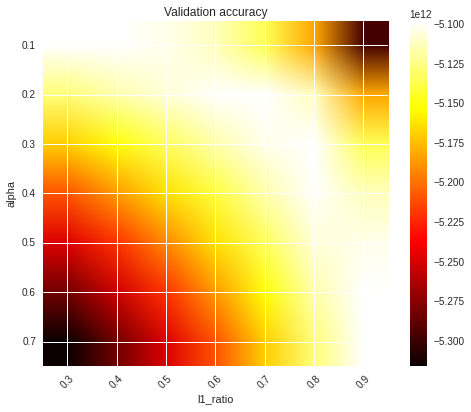

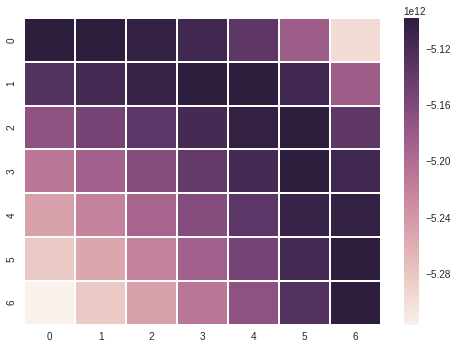

In [115]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(alpha_range), len(l1_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, cmap=plt.cm.hot)
plt.xlabel('l1_ratio')
plt.ylabel('alpha')
plt.colorbar()
plt.xticks(np.arange(len(l1_range)), l1_range, rotation=45)
plt.yticks(np.arange(len(alpha_range)), alpha_range)
plt.title('Validation accuracy')
plt.show()

sns.heatmap(scores)

In [120]:
# NMF on all-samples valid-columns. Fit to unlabelled.

print(cols_)

alpha_range = np.linspace(0.2, 0.4, 10)
l1_range = np.linspace(0.6, 0.8, 10)
parameters = dict(alpha=alpha_range, l1_ratio=l1_range)

clf = sklearn.linear_model.ElasticNet()
clf = sklearn.grid_search.GridSearchCV(clf, parameters, scoring=scorer, cv=cv25by10, n_jobs=1)
clf.fit(X_, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
The best parameters are {'alpha': 0.20000000000000001, 'l1_ratio': 0.66666666666666663} with a score of 2257756.01


[mean: -5099196991149.75293, std: 3281425162445.19678, params: {'alpha': 0.20000000000000001, 'l1_ratio': 0.59999999999999998},
 mean: -5098253384470.43945, std: 3275800738092.29883, params: {'alpha': 0.20000000000000001, 'l1_ratio': 0.62222222222222223},
 mean: -5097650362583.88965, std: 3270083924124.08691, params: {'alpha': 0.20000000000000001, 'l1_ratio': 0.64444444444444449},
 mean: -5097462203392.99805, std: 3264274661543.96631, params: {'alpha': 0.20000000000000001, 'l1_ratio': 0.66666666666666663},
 mean: -5097782982708.39844, std: 3258374210210.34131, params: {'alpha': 0.20000000000000001, 'l1_ratio': 0.68888888888888888},
 mean: -5098733237466.59082, std: 3252386030308.79541, params: {'alpha': 0.20000000000000001, 'l1_ratio': 0.71111111111111114},
 mean: -5100469518948.60059, std: 3246316762808.94336, params: {'alpha': 0.20000000000000001, 'l1_ratio': 0.73333333333333339},
 mean: -5103198395038.33301, std: 3240178200536.18115, params: {'alpha': 0.20000000000000001, 'l1_ratio'

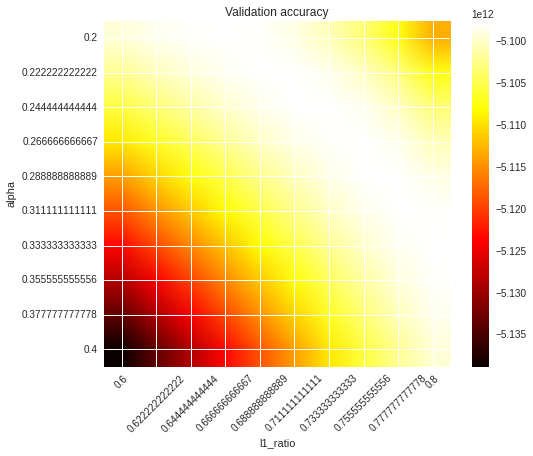

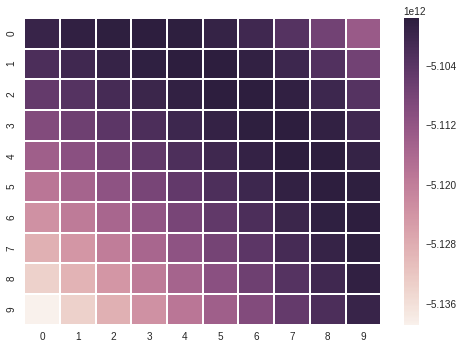

In [121]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(alpha_range), len(l1_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, cmap=plt.cm.hot)
plt.xlabel('l1_ratio')
plt.ylabel('alpha')
plt.colorbar()
plt.xticks(np.arange(len(l1_range)), l1_range, rotation=45)
plt.yticks(np.arange(len(alpha_range)), alpha_range)
plt.title('Validation accuracy')
plt.show()

sns.heatmap(scores)

In [ ]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

alpha_range = [0.1, 0.3, 0.5, 0.7]
l1_range = [0.1, 0.3, 0.5, 0.6, 0.8, 0.9]
parameters = dict(alpha=alpha_range, l1_ratio=l1_range)

clf = sklearn.linear_model.ElasticNet()
clf = sklearn.grid_search.GridSearchCV(clf, parameters, scoring=scorer, cv=10, n_jobs=1)

support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2441097.78 with PV_NMF_0


In [122]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNet(alpha=0.25, l1_ratio=0.72)
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2483252.45 with PV_NMF_0
	Scored 2473357.45 with PV_NMF_1
	Scored 2508200.75 with PV_NMF_2
	Scored 2498852.60 with PV_NMF_3
	Scored 2508219.69 with PV_NMF_4
	Scored 2501677.25 with PV_NMF_5
	Scored 2478539.85 with PV_NMF_6
	Scored 2508704.34 with PV_NMF_7
	Scored 2500018.98 with PV_NMF_8
	Scored 2507870.97 with PV_NMF_9
	Scored 2483050.67 with PV_NMF_10
	Scored 2483201.50 with PV_NMF_11
	Scored 2515708.99 with PV_NMF_12
	Scored 2516288.02 with PV_NMF_13
	Scored 2494707.78 with PV_NMF_14
	Scored 2501545.02 with PV_NMF_15
	Scored 2510758.36 with PV_NMF_16
	Scored 2511052.46 with PV_NMF_17
	Scored 2513652.00 with PV_NMF_18
	Scored 2500110.22 with PV_NMF_19
	

In [125]:
# NMF on all-samples valid-columns. Fit to unlabelled.

cc = ['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_6', 'PV_NMF_11', 'PV_NMF_13',
      'PV_NMF_17', 'PV_NMF_19', 'Age', 'isIstanbul', 'isIzmir', 'isIL']

print(cols_)

print(cc)

li = np.array([c in cc for c in cols_])
X_2 = X_[:,li]

alpha_range = np.linspace(0.1, 0.9, 10)
l1_range = np.linspace(0.1, 0.9, 10)
parameters = dict(alpha=alpha_range, l1_ratio=l1_range)

clf = sklearn.linear_model.ElasticNet()
clf = sklearn.grid_search.GridSearchCV(clf, parameters, scoring=scorer, cv=cv25by10, n_jobs=6)
clf.fit(X_2, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_6', 'PV_NMF_11', 'PV_NMF_13', 'PV_NMF_17', 'PV_NMF_19', 'Age', 'isIstanbul', 'isIzmir', 'isIL']
The best parameters are {'alpha': 0.10000000000000001, 'l1_ratio': 0.81111111111111112} with a score of 2202539.70


[mean: -4979131438042.91309, std: 3262183195460.77588, params: {'alpha': 0.10000000000000001, 'l1_ratio': 0.10000000000000001},
 mean: -4962642687305.40918, std: 3242773965792.92480, params: {'alpha': 0.10000000000000001, 'l1_ratio': 0.18888888888888888},
 mean: -4945577210354.37988, std: 3221671699981.39307, params: {'alpha': 0.10000000000000001, 'l1_ratio': 0.27777777777777779},
 mean: -4928020259813.28711, std: 3198531901927.63379, params: {'alpha': 0.10000000000000001, 'l1_ratio': 0.3666666666666667},
 mean: -4910155464867.25098, std: 3172884213331.17188, params: {'alpha': 0.10000000000000001, 'l1_ratio': 0.4555555555555556},
 mean: -4892348929724.34277, std: 3144056319332.91504, params: {'alpha': 0.10000000000000001, 'l1_ratio': 0.54444444444444451},
 mean: -4875319855762.58691, std: 3111023049748.53760, params: {'alpha': 0.10000000000000001, 'l1_ratio': 0.6333333333333333},
 mean: -4860523134764.89746, std: 3072060944033.76758, params: {'alpha': 0.10000000000000001, 'l1_ratio': 0

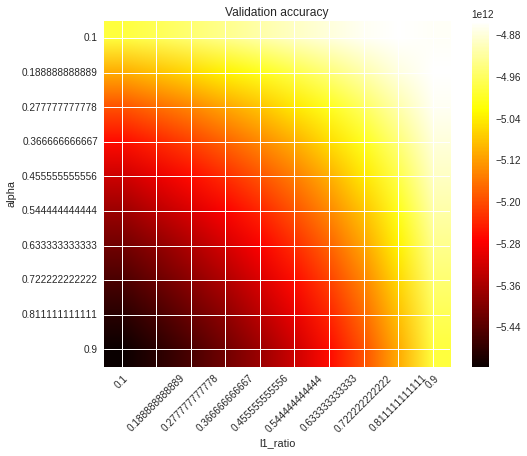

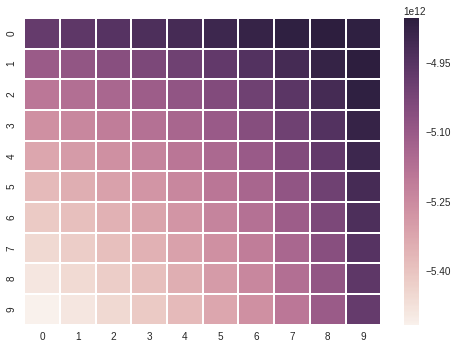

In [ ]:
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(alpha_range), len(l1_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, cmap=plt.cm.hot)
plt.xlabel('l1_ratio')
plt.ylabel('alpha')
plt.colorbar()
plt.xticks(np.arange(len(l1_range)), l1_range, rotation=45)
plt.yticks(np.arange(len(alpha_range)), alpha_range)
plt.title('Validation accuracy')
plt.show()

sns.heatmap(scores)

In [ ]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

alpha_range = [0.1, 0.3, 0.5, 0.7]
l1_range = [0.1, 0.3, 0.5, 0.6, 0.8, 0.9]
parameters = dict(alpha=alpha_range, l1_ratio=l1_range)

clf = sklearn.linear_model.ElasticNet()
clf = sklearn.grid_search.GridSearchCV(clf, parameters, scoring=scorer, cv=10, n_jobs=5)

support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2441097.78 with PV_NMF_0
	Scored 2462433.00 with PV_NMF_1
	Scored 2513462.42 with PV_NMF_2
	Scored 2478589.01 with PV_NMF_3
	Scored 2513493.35 with PV_NMF_4
	Scored 2500205.27 with PV_NMF_5
	Scored 2446856.66 with PV_NMF_6
	Scored 2515469.48 with PV_NMF_7
	Scored 2500752.01 with PV_NMF_8


Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x7f0a5c9ba950>
Traceback (most recent call last):
  File "/usr/lib/python3.4/weakref.py", line 102, in remove
    def remove(wr, selfref=ref(self)):
KeyboardInterrupt


	Scored 2526628.87 with PV_NMF_9
	Scored 2461093.52 with PV_NMF_10
	Scored 2466187.92 with PV_NMF_11
	Scored 2512289.72 with PV_NMF_12
	Scored 2517575.48 with PV_NMF_13
	Scored 2469935.80 with PV_NMF_14
	Scored 2509899.16 with PV_NMF_15
	Scored 2515036.96 with PV_NMF_16
	Scored 2523444.97 with PV_NMF_17
	Scored 2512162.74 with PV_NMF_18
	Scored 2501427.10 with PV_NMF_19
	Scored 2384339.07 with Age
	Scored 2422575.88 with isBig
	Scored 2407890.24 with isIstanbul
	Scored 2525421.94 with isAnkara
	Scored 2518426.05 with isIzmir
	Scored 2515185.82 with isIL
	Scored 2515505.95 with missingSource
Adding feature Age (scored 2384339.065629988)


Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x7f0a5c9ba950>
Traceback (most recent call last):
  File "/usr/lib/python3.4/weakref.py", line 102, in remove
    def remove(wr, selfref=ref(self)):
KeyboardInterrupt


In [32]:
XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

In [33]:
# NMF on all-samples valid-columns. Fit to unlabelled.

cc = ['PV_NMF_0', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_6', 'PV_NMF_11', 'PV_NMF_15', 'PV_NMF_17', 
      'PV_NMF_19', 'Age', 'isIstanbul', 'isIL']

print(cols_)

print(cc)

li = np.array([c in cc for c in cols_])
X_2 = X_[:,li]

alpha_range = np.linspace(0.1, 0.9, 10)
parameters = dict(alpha=alpha_range)

clf = sklearn.linear_model.Ridge()
clf = sklearn.grid_search.GridSearchCV(clf, parameters, scoring=scorer, cv=cv25by10, n_jobs=6)
clf.fit(X_2, y)

print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, np.sqrt(-clf.best_score_)))

clf.grid_scores_

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
['PV_NMF_0', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_6', 'PV_NMF_11', 'PV_NMF_15', 'PV_NMF_17', 'PV_NMF_19', 'Age', 'isIstanbul', 'isIL']
The best parameters are {'alpha': 0.72222222222222221} with a score of 2187969.92


[mean: -4824226185644.54590, std: 2736447124509.12012, params: {'alpha': 0.10000000000000001},
 mean: -4811857307489.95801, std: 2757738781952.42920, params: {'alpha': 0.18888888888888888},
 mean: -4802803513387.03320, std: 2777585155071.87012, params: {'alpha': 0.27777777777777779},
 mean: -4796339631256.54102, std: 2796109283196.45898, params: {'alpha': 0.3666666666666667},
 mean: -4791921020698.12500, std: 2813428780516.51514, params: {'alpha': 0.4555555555555556},
 mean: -4789131060008.77051, std: 2829652303032.18945, params: {'alpha': 0.54444444444444451},
 mean: -4787646269477.69531, std: 2844878544932.55859, params: {'alpha': 0.6333333333333333},
 mean: -4787212375942.16211, std: 2859196386578.02539, params: {'alpha': 0.72222222222222221},
 mean: -4787627434306.83887, std: 2872685541754.53027, params: {'alpha': 0.81111111111111112},
 mean: -4788729652015.69238, std: 2885417389549.39404, params: {'alpha': 0.90000000000000002}]

In [34]:
# NMF on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PVcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Ridge(alpha=0.72)
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2434603.89 with PV_NMF_0
	Scored 2460279.81 with PV_NMF_1
	Scored 2505504.27 with PV_NMF_2
	Scored 2476736.67 with PV_NMF_3
	Scored 2506761.70 with PV_NMF_4
	Scored 2488983.49 with PV_NMF_5
	Scored 2444208.76 with PV_NMF_6
	Scored 2506931.12 with PV_NMF_7
	Scored 2491443.69 with PV_NMF_8
	Scored 2513896.01 with PV_NMF_9
	Scored 2459001.02 with PV_NMF_10
	Scored 2465237.48 with PV_NMF_11
	Scored 2526026.71 with PV_NMF_12
	Scored 2528386.91 with PV_NMF_13
	Scored 2466594.50 with PV_NMF_14
	Scored 2500583.71 with PV_NMF_15
	Scored 2510085.18 with PV_NMF_16
	Scored 2515901.27 with PV_NMF_17
	Scored 2520133.58 with PV_NMF_18
	Scored 2497674.98 with PV_NMF_19
	

In [35]:
# LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = ['PV_PCA_'+str(i) for i in range(XPCA_.shape[1])]

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]

X_ = np.concatenate((XPV, XPCA_, XNMF_, XG, XO), axis=1)
cols_ = PVcols + PCAcols_ + PNMFcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNet()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'PV_PCA_0', 'PV_PCA_1', 'PV_PCA_2', 'PV_PCA_3', 'PV_PCA_4', 'PV_PCA_5', 'PV_PCA_6', 'PV_PCA_7', 'PV_PCA_8', 'PV_PCA_9', 'PV_PCA_10', 'PV_PCA_11', 'PV_PCA_12', 'PV_PCA_13', 'PV_PCA_14', 'PV_PCA_15', 'PV_PCA_16', 'PV_PCA_17', 'PV_PCA_18', 'PV_PCA_19', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2493350.58 with P1
	Scored 2462283.70 with P2
	Scored 2517735.01 with P3
	Scored 2514979.24 with P4
	Scored 2519226.37 with P5
	Scored 2466855.99 with P6
	Scored 2508218.04 with P7
	Scored 2499277.94 with P8
	Scored 2512244.42 with P9
	Scored 2508579.48 with P10
	Scored 2497809.03 

In [36]:
# PCA on all-samples valid-columns. Fit to unlabelled.

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = ['PV_PCA_'+str(i) for i in range(XPCA_.shape[1])]

X_ = np.concatenate((XPCA_, XG, XO), axis=1)
cols_ = PCAcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNet()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_PCA_0', 'PV_PCA_1', 'PV_PCA_2', 'PV_PCA_3', 'PV_PCA_4', 'PV_PCA_5', 'PV_PCA_6', 'PV_PCA_7', 'PV_PCA_8', 'PV_PCA_9', 'PV_PCA_10', 'PV_PCA_11', 'PV_PCA_12', 'PV_PCA_13', 'PV_PCA_14', 'PV_PCA_15', 'PV_PCA_16', 'PV_PCA_17', 'PV_PCA_18', 'PV_PCA_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2515428.77 with PV_PCA_0
	Scored 2430474.25 with PV_PCA_1
	Scored 2512968.46 with PV_PCA_2
	Scored 2501056.89 with PV_PCA_3
	Scored 2501025.73 with PV_PCA_4
	Scored 2504639.65 with PV_PCA_5
	Scored 2512267.17 with PV_PCA_6
	Scored 2509442.37 with PV_PCA_7
	Scored 2497119.02 with PV_PCA_8
	Scored 2519569.72 with PV_PCA_9
	Scored 2493851.85 with PV_PCA_10
	Scored 2513266.52 with PV_PCA_11
	Scored 2516749.42 with PV_PCA_12
	Scored 2504165.40 with PV_PCA_13
	Scored 2517968.23 with PV_PCA_14
	Scored 2517437.64 with PV_PCA_15
	Scored 2504153.01 with PV_PCA_16
	Scored 2510145.66 with PV_PCA_17
	Scored 2513364.10 with PV_PCA_18
	Scored 2511262.61 with PV_PCA_19
	

In [37]:
# PCA on all-samples valid-columns. Fit to unlabelled.

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = ['PV_PCA_'+str(i) for i in range(XPCA_.shape[1])]

X_ = np.concatenate((XPCA_, XG, XO), axis=1)
cols_ = PCAcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Ridge()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_PCA_0', 'PV_PCA_1', 'PV_PCA_2', 'PV_PCA_3', 'PV_PCA_4', 'PV_PCA_5', 'PV_PCA_6', 'PV_PCA_7', 'PV_PCA_8', 'PV_PCA_9', 'PV_PCA_10', 'PV_PCA_11', 'PV_PCA_12', 'PV_PCA_13', 'PV_PCA_14', 'PV_PCA_15', 'PV_PCA_16', 'PV_PCA_17', 'PV_PCA_18', 'PV_PCA_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2515836.78 with PV_PCA_0
	Scored 2431876.79 with PV_PCA_1
	Scored 2514914.30 with PV_PCA_2
	Scored 2504094.90 with PV_PCA_3
	Scored 2505245.31 with PV_PCA_4
	Scored 2508158.03 with PV_PCA_5
	Scored 2517703.49 with PV_PCA_6
	Scored 2512531.59 with PV_PCA_7
	Scored 2495832.09 with PV_PCA_8
	Scored 2532969.21 with PV_PCA_9
	Scored 2490524.04 with PV_PCA_10
	Scored 2521700.69 with PV_PCA_11
	Scored 2530025.34 with PV_PCA_12
	Scored 2501256.60 with PV_PCA_13
	Scored 2536369.49 with PV_PCA_14
	Scored 2539802.53 with PV_PCA_15
	Scored 2499330.38 with PV_PCA_16
	Scored 2512725.20 with PV_PCA_17
	Scored 2525393.14 with PV_PCA_18
	Scored 2512632.19 with PV_PCA_19
	

In [41]:
# LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

XNMF_ = sklearn.decomposition.NMF(n_components=7, random_state=888, tol=0.000001, max_iter=10000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]

X_ = np.concatenate((XNMF_, XG, XO), axis=1)
cols_ = PNMFcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Ridge()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2479294.51 with PV_NMF_0
	Scored 2498637.56 with PV_NMF_1
	Scored 2517227.39 with PV_NMF_2
	Scored 2453342.30 with PV_NMF_3
	Scored 2500699.32 with PV_NMF_4
	Scored 2482051.39 with PV_NMF_5
	Scored 2524547.09 with PV_NMF_6
	Scored 2383160.10 with Age
	Scored 2420836.57 with isBig
	Scored 2406048.40 with isIstanbul
	Scored 2523649.32 with isAnkara
	Scored 2528624.22 with isIzmir
	Scored 2509550.28 with isIL
	Scored 2524467.19 with missingSource
Adding feature Age (scored 2383160.1006735205)
	Scored 2377028.01 with PV_NMF_0, Age
	Scored 2392143.81 with PV_NMF_1, Age
	Scored 2389453.45 with PV_NMF_2, Age
	Scored 2341032.19 with PV_NMF_3, Age
	Scored 2387648.75 with PV_NMF_4, Age
	Scored 2379345.55 with PV_NMF_5, Age
	Scored 2398091.06 with PV_NMF_6, Age
	Scored 2328771.43 with Age, isBig
	Scored 2318384.54 with Age, isIs

In [39]:
# LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = ['PV_PCA_'+str(i) for i in range(XPV_.shape[1])]

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV, XPCA_, XNMF_, XG, XO), axis=1)
cols_ = PVcols + PCAcols_ + PNMFcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Ridge()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'PV_PCA_0', 'PV_PCA_1', 'PV_PCA_2', 'PV_PCA_3', 'PV_PCA_4', 'PV_PCA_5', 'PV_PCA_6', 'PV_PCA_7', 'PV_PCA_8', 'PV_PCA_9', 'PV_PCA_10', 'PV_PCA_11', 'PV_PCA_12', 'PV_PCA_13', 'PV_PCA_14', 'PV_PCA_15', 'PV_PCA_16', 'PV_PCA_17', 'PV_PCA_18', 'PV_PCA_19', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2493665.24 with P1
	Scored 2459343.83 with P2
	Scored 2520647.68 with P3
	Scored 2517745.99 with P4
	Scored 2523207.88 with P5
	Scored 2465578.23 with P6
	Scored 2509231.15 with P7
	Scored 2501499.35 with P8
	Scored 2515673.40 with P9
	Scored 2513481.01 with P10
	Scored 2498740.83 

In [42]:
# LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = ['PV_PCA_'+str(i) for i in range(XPV_.shape[1])]

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV, XPCA_, XNMF_, XG, XO), axis=1)
cols_ = PVcols + PCAcols_ + PNMFcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.Ridge(alpha=0.72)
support, ranking = rfa(clf, X_, y, col_names=cols_)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'PV_PCA_0', 'PV_PCA_1', 'PV_PCA_2', 'PV_PCA_3', 'PV_PCA_4', 'PV_PCA_5', 'PV_PCA_6', 'PV_PCA_7', 'PV_PCA_8', 'PV_PCA_9', 'PV_PCA_10', 'PV_PCA_11', 'PV_PCA_12', 'PV_PCA_13', 'PV_PCA_14', 'PV_PCA_15', 'PV_PCA_16', 'PV_PCA_17', 'PV_PCA_18', 'PV_PCA_19', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2493683.61 with P1
	Scored 2459363.54 with P2
	Scored 2520664.10 with P3
	Scored 2517764.12 with P4
	Scored 2523231.04 with P5
	Scored 2465600.31 with P6
	Scored 2509241.97 with P7
	Scored 2501525.44 with P8
	Scored 2515698.41 with P9
	Scored 2513518.39 with P10
	Scored 2498762.33 

In [44]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

X_list.append(XPV)
cols_ += PVcols

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = ['PV_PCA_'+str(i) for i in range(XPCA_.shape[1])]
X_list.append(XPCA_)
cols_ += PCAcols_

XICA_ = sklearn.decomposition.FastICA(random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
PICAcols_ = ['PV_ICA_'+str(i) for i in range(XICA_.shape[1])]
X_list.append(XICA_)
cols_ += PICAcols_

XFA_ = sklearn.decomposition.FactorAnalysis(random_state=888, tol=0.000001).fit(uXPV).transform(XPV)
PFAcols_ = ['PV_FA_'+str(i) for i in range(XFA_.shape[1])]
X_list.append(XFA_)
cols_ += PFAcols_

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]
X_list.append(XNMF_)
cols_ += PNMFcols_

XLLE_ = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=8, n_components=XPV_.shape[1], random_state=888).fit(uXPV).transform(XPV)
PLLEcols_ = ['PV_LLE_'+str(i) for i in range(XLLE_.shape[1])]
X_list.append(XLLE_)
cols_ += PLLEcols_

uXMDS_ = sklearn.manifold.MDS(n_components=XPV_.shape[1], random_state=888).fit_transform(uXPV)
XMDS_ = uXMDS_[index_is_labelled,:]
PMDScols_ = ['PV_MDS_'+str(i) for i in range(XMDS_.shape[1])]
X_list.append(XMDS_)
cols_ += PMDScols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

clf = sklearn.linear_model.Ridge()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'PV_PCA_0', 'PV_PCA_1', 'PV_PCA_2', 'PV_PCA_3', 'PV_PCA_4', 'PV_PCA_5', 'PV_PCA_6', 'PV_PCA_7', 'PV_PCA_8', 'PV_PCA_9', 'PV_PCA_10', 'PV_PCA_11', 'PV_PCA_12', 'PV_PCA_13', 'PV_PCA_14', 'PV_PCA_15', 'PV_PCA_16', 'PV_PCA_17', 'PV_PCA_18', 'PV_PCA_19', 'PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19', 'PV_FA_0', 'PV_FA_1', 'PV_FA_2', 'PV_FA_3', 'PV_FA_4', 'PV_FA_5', 'PV_FA_6', 'PV_FA_7', 'PV_FA_8', 'PV_FA_9', 'PV_FA_10', 'PV_FA_11', 'PV_FA_12', 'PV_FA_13', 'PV_FA_14', 'PV_FA_15', 'PV_FA_16', 'PV_FA_17', 'PV_FA_18', 'PV_FA_19', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 

/usr/local/lib/python3.4/dist-packages/sklearn/decomposition/fastica_.py:110: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


# OVERNIGHT RUN

In [56]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

X_list.append(XPV)
cols_ += PVcols

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = ['PV_PCA_'+str(i) for i in range(XPCA_.shape[1])]
X_list.append(XPCA_)
cols_ += PCAcols_

XICA_ = sklearn.decomposition.FastICA(random_state=889, max_iter=50000, tol=0.000001).fit(uXPV).transform(XPV)
PICAcols_ = ['PV_ICA_'+str(i) for i in range(XICA_.shape[1])]
X_list.append(XICA_)
cols_ += PICAcols_

XFA_ = sklearn.decomposition.FactorAnalysis(random_state=888, tol=0.000001).fit(uXPV).transform(XPV)
PFAcols_ = ['PV_FA_'+str(i) for i in range(XFA_.shape[1])]
X_list.append(XFA_)
cols_ += PFAcols_

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]
X_list.append(XNMF_)
cols_ += PNMFcols_

XLLE_ = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=8, n_components=XPV.shape[1], random_state=888).fit(uXPV).transform(XPV)
PLLEcols_ = ['PV_LLE_'+str(i) for i in range(XLLE_.shape[1])]
X_list.append(XLLE_)
cols_ += PLLEcols_

uXMDS_ = sklearn.manifold.MDS(n_components=XPV.shape[1], random_state=888).fit_transform(uXPV)
XMDS_ = uXMDS_[index_is_labelled,:]
PMDScols_ = ['PV_MDS_'+str(i) for i in range(XMDS_.shape[1])]
X_list.append(XMDS_)
cols_ += PMDScols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P19', 'P20', 'P21', 'P22', 'P23', 'P28', 'P29', 'PV_PCA_0', 'PV_PCA_1', 'PV_PCA_2', 'PV_PCA_3', 'PV_PCA_4', 'PV_PCA_5', 'PV_PCA_6', 'PV_PCA_7', 'PV_PCA_8', 'PV_PCA_9', 'PV_PCA_10', 'PV_PCA_11', 'PV_PCA_12', 'PV_PCA_13', 'PV_PCA_14', 'PV_PCA_15', 'PV_PCA_16', 'PV_PCA_17', 'PV_PCA_18', 'PV_PCA_19', 'PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19', 'PV_FA_0', 'PV_FA_1', 'PV_FA_2', 'PV_FA_3', 'PV_FA_4', 'PV_FA_5', 'PV_FA_6', 'PV_FA_7', 'PV_FA_8', 'PV_FA_9', 'PV_FA_10', 'PV_FA_11', 'PV_FA_12', 'PV_FA_13', 'PV_FA_14', 'PV_FA_15', 'PV_FA_16', 'PV_FA_17', 'PV_FA_18', 'PV_FA_19', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 

In [57]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = ['PV_PCA_'+str(i) for i in range(XPCA_.shape[1])]
X_list.append(XPCA_)
cols_ += PCAcols_

XICA_ = sklearn.decomposition.FastICA(random_state=889, max_iter=50000, tol=0.000001).fit(uXPV).transform(XPV)
PICAcols_ = ['PV_ICA_'+str(i) for i in range(XICA_.shape[1])]
X_list.append(XICA_)
cols_ += PICAcols_

XFA_ = sklearn.decomposition.FactorAnalysis(random_state=888, tol=0.000001).fit(uXPV).transform(XPV)
PFAcols_ = ['PV_FA_'+str(i) for i in range(XFA_.shape[1])]
X_list.append(XFA_)
cols_ += PFAcols_

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]
X_list.append(XNMF_)
cols_ += PNMFcols_

XLLE_ = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=8, n_components=XPV.shape[1], random_state=888).fit(uXPV).transform(XPV)
PLLEcols_ = ['PV_LLE_'+str(i) for i in range(XLLE_.shape[1])]
X_list.append(XLLE_)
cols_ += PLLEcols_

uXMDS_ = sklearn.manifold.MDS(n_components=XPV.shape[1], random_state=888).fit_transform(uXPV)
XMDS_ = uXMDS_[index_is_labelled,:]
PMDScols_ = ['PV_MDS_'+str(i) for i in range(XMDS_.shape[1])]
X_list.append(XMDS_)
cols_ += PMDScols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'PV_PCA_0', 'PV_PCA_1', 'PV_PCA_2', 'PV_PCA_3', 'PV_PCA_4', 'PV_PCA_5', 'PV_PCA_6', 'PV_PCA_7', 'PV_PCA_8', 'PV_PCA_9', 'PV_PCA_10', 'PV_PCA_11', 'PV_PCA_12', 'PV_PCA_13', 'PV_PCA_14', 'PV_PCA_15', 'PV_PCA_16', 'PV_PCA_17', 'PV_PCA_18', 'PV_PCA_19', 'PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19', 'PV_FA_0', 'PV_FA_1', 'PV_FA_2', 'PV_FA_3', 'PV_FA_4', 'PV_FA_5', 'PV_FA_6', 'PV_FA_7', 'PV_FA_8', 'PV_FA_9', 'PV_FA_10', 'PV_FA_11', 'PV_FA_12', 'PV_FA_13', 'PV_FA_14', 'PV_FA_15', 'PV_FA_16', 'PV_FA_17', 'PV_FA_18', 'PV_FA_19', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NM

In [58]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = ['PV_PCA_'+str(i) for i in range(XPCA_.shape[1])]
X_list.append(XPCA_)
cols_ += PCAcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'PV_PCA_0', 'PV_PCA_1', 'PV_PCA_2', 'PV_PCA_3', 'PV_PCA_4', 'PV_PCA_5', 'PV_PCA_6', 'PV_PCA_7', 'PV_PCA_8', 'PV_PCA_9', 'PV_PCA_10', 'PV_PCA_11', 'PV_PCA_12', 'PV_PCA_13', 'PV_PCA_14', 'PV_PCA_15', 'PV_PCA_16', 'PV_PCA_17', 'PV_PCA_18', 'PV_PCA_19']
Adding feature Age (scored 2285860.497943715)
Adding feature PV_PCA_10 (scored 2220492.200460409)
Adding feature isIstanbul (scored 2168077.251603505)
Adding feature PV_PCA_7 (scored 2139257.142269217)
Adding feature isIL (scored 2128068.8294105916)
Adding feature PV_PCA_8 (scored 2110962.1486492087)
Adding feature PV_PCA_16 (scored 2103339.8913703305)
Adding feature PV_PCA_2 (scored 2099707.7808976923)
No more improvement possible from 8 to 9 features
Best score is 2099707.7808976923 with features:
	Age, isIstanbul, isIL, PV_PCA_2, PV_PCA_7, PV_PCA_8, PV_PCA_10, PV_PCA_16
------------------
['Age' 'isIstanbul' 'isIL' 'PV_PCA_2' 'PV_PCA_7' 'PV_PCA_8' 'PV_PCA_10'


In [59]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

XICA_ = sklearn.decomposition.FastICA(random_state=889, max_iter=50000, tol=0.000001).fit(uXPV).transform(XPV)
PICAcols_ = ['PV_ICA_'+str(i) for i in range(XICA_.shape[1])]
X_list.append(XICA_)
cols_ += PICAcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19']
Adding feature Age (scored 2285860.497943715)
Adding feature isIstanbul (scored 2231162.8176329993)
Adding feature isIL (scored 2201043.1738617867)
Adding feature PV_ICA_7 (scored 2190538.547911002)
Adding feature PV_ICA_10 (scored 2185338.2734208205)
Adding feature PV_ICA_9 (scored 2180376.8840258145)
Adding feature PV_ICA_18 (scored 2176315.0922392737)
Adding feature isIzmir (scored 2173344.1207579244)
Adding feature PV_ICA_1 (scored 2171227.8555953293)
Adding feature PV_ICA_8 (scored 2169419.486411243)
Adding feature PV_ICA_17 (scored 2168031.548015528)
Adding feature PV_ICA_15 (scored 2166865.42502051)
Adding feature PV_ICA_0 (scored 2165934.596974301)
No mor

In [60]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

XFA_ = sklearn.decomposition.FactorAnalysis(random_state=888, tol=0.000001).fit(uXPV).transform(XPV)
PFAcols_ = ['PV_FA_'+str(i) for i in range(XFA_.shape[1])]
X_list.append(XFA_)
cols_ += PFAcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'PV_FA_0', 'PV_FA_1', 'PV_FA_2', 'PV_FA_3', 'PV_FA_4', 'PV_FA_5', 'PV_FA_6', 'PV_FA_7', 'PV_FA_8', 'PV_FA_9', 'PV_FA_10', 'PV_FA_11', 'PV_FA_12', 'PV_FA_13', 'PV_FA_14', 'PV_FA_15', 'PV_FA_16', 'PV_FA_17', 'PV_FA_18', 'PV_FA_19']
Adding feature Age (scored 2285860.497943715)
Adding feature isIstanbul (scored 2231162.8176329993)
Adding feature isIL (scored 2201043.1738617867)
Adding feature isIzmir (scored 2197951.6042689187)
No more improvement possible from 4 to 5 features
Best score is 2197951.6042689187 with features:
	Age, isIstanbul, isIzmir, isIL
------------------
['Age' 'isIstanbul' 'isIzmir' 'isIL']
Fold 0 Scored 2984233.9126541396
------------------
Adding feature isIstanbul (scored 2371344.7225839663)
Adding feature Age (scored 2307601.393125223)
Adding feature isIL (scored 2269209.0559759135)
Adding feature PV_FA_1 (scored 2231408.255869593)
Adding feature isIzmir (scored 2219854.7385996887)
No m

In [61]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]
X_list.append(XNMF_)
cols_ += PNMFcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19']
Adding feature Age (scored 2285860.497943715)
Adding feature PV_NMF_0 (scored 2225078.1330120624)
Adding feature PV_NMF_11 (scored 2183186.5187525284)
Adding feature isIstanbul (scored 2162978.696854499)
Adding feature PV_NMF_17 (scored 2153972.39032681)
Adding feature PV_NMF_3 (scored 2144523.843026296)
Adding feature PV_NMF_6 (scored 2132075.5376394154)
Adding feature isIL (scored 2130921.3386704363)
Adding feature PV_NMF_2 (scored 2129492.5275478945)
Adding feature PV_NMF_19 (scored 2126363.5250909557)
Adding feature PV_NMF_15 (scored 2122616.2953491663)
No more improvement possible from 11 to 12 features
Best score is 2122616.2953491663 with features:
	Age, i

In [62]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

XLLE_ = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=8, n_components=XPV.shape[1], random_state=888).fit(uXPV).transform(XPV)
PLLEcols_ = ['PV_LLE_'+str(i) for i in range(XLLE_.shape[1])]
X_list.append(XLLE_)
cols_ += PLLEcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'PV_LLE_0', 'PV_LLE_1', 'PV_LLE_2', 'PV_LLE_3', 'PV_LLE_4', 'PV_LLE_5', 'PV_LLE_6', 'PV_LLE_7', 'PV_LLE_8', 'PV_LLE_9', 'PV_LLE_10', 'PV_LLE_11', 'PV_LLE_12', 'PV_LLE_13', 'PV_LLE_14', 'PV_LLE_15', 'PV_LLE_16', 'PV_LLE_17', 'PV_LLE_18', 'PV_LLE_19']
Adding feature Age (scored 2285860.497943715)
Adding feature isIstanbul (scored 2231162.8176329993)
Adding feature isIL (scored 2201043.1738617867)
Adding feature PV_LLE_10 (scored 2184876.3037716593)
Adding feature PV_LLE_17 (scored 2182148.167916026)
Adding feature PV_LLE_3 (scored 2180180.217214999)
Adding feature PV_LLE_11 (scored 2179022.5258060945)
Adding feature PV_LLE_6 (scored 2178613.80256863)
No more improvement possible from 8 to 9 features
Best score is 2178613.80256863 with features:
	Age, isIstanbul, isIL, PV_LLE_3, PV_LLE_6, PV_LLE_10, PV_LLE_11, PV_LLE_17
------------------
['Age' 'isIstanbul' 'isIL' 'PV_LLE_3' 'PV_LLE_6' 'PV_LLE_10' 'PV_LLE_11'


In [63]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

uXMDS_ = sklearn.manifold.MDS(n_components=XPV.shape[1], random_state=888).fit_transform(uXPV)
XMDS_ = uXMDS_[index_is_labelled,:]
PMDScols_ = ['PV_MDS_'+str(i) for i in range(XMDS_.shape[1])]
X_list.append(XMDS_)
cols_ += PMDScols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'PV_MDS_0', 'PV_MDS_1', 'PV_MDS_2', 'PV_MDS_3', 'PV_MDS_4', 'PV_MDS_5', 'PV_MDS_6', 'PV_MDS_7', 'PV_MDS_8', 'PV_MDS_9', 'PV_MDS_10', 'PV_MDS_11', 'PV_MDS_12', 'PV_MDS_13', 'PV_MDS_14', 'PV_MDS_15', 'PV_MDS_16', 'PV_MDS_17', 'PV_MDS_18', 'PV_MDS_19']
Adding feature Age (scored 2285860.497943715)
Adding feature isIstanbul (scored 2231162.8176329993)
Adding feature isIL (scored 2201043.1738617867)
Adding feature PV_MDS_14 (scored 2176876.002477447)
Adding feature PV_MDS_0 (scored 2129130.0744242673)
Adding feature PV_MDS_18 (scored 2118061.507731183)
Adding feature PV_MDS_15 (scored 2115307.8878072686)
No more improvement possible from 7 to 8 features
Best score is 2115307.8878072686 with features:
	Age, isIstanbul, isIL, PV_MDS_0, PV_MDS_14, PV_MDS_15, PV_MDS_18
------------------
['Age' 'isIstanbul' 'isIL' 'PV_MDS_0' 'PV_MDS_14' 'PV_MDS_15' 'PV_MDS_18']
Fold 0 Scored 2953710.797636203
------------------
Addin

In [71]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
cols_ += Gcols

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = ['PV_PCA_'+str(i) for i in range(XPCA_.shape[1])]
X_list.append(XPCA_)
cols_ += PCAcols_

XICA_ = sklearn.decomposition.FastICA(random_state=889, max_iter=50000, tol=0.000001).fit(uXPV).transform(XPV)
PICAcols_ = ['PV_ICA_'+str(i) for i in range(XICA_.shape[1])]
X_list.append(XICA_)
cols_ += PICAcols_

XFA_ = sklearn.decomposition.FactorAnalysis(random_state=888, tol=0.000001).fit(uXPV).transform(XPV)
PFAcols_ = ['PV_FA_'+str(i) for i in range(XFA_.shape[1])]
X_list.append(XFA_)
cols_ += PFAcols_

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]
X_list.append(XNMF_)
cols_ += PNMFcols_

XLLE_ = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=8, n_components=XPV.shape[1], random_state=888).fit(uXPV).transform(XPV)
PLLEcols_ = ['PV_LLE_'+str(i) for i in range(XLLE_.shape[1])]
X_list.append(XLLE_)
cols_ += PLLEcols_

uXMDS_ = sklearn.manifold.MDS(n_components=XPV.shape[1], random_state=888).fit_transform(uXPV)
XMDS_ = uXMDS_[index_is_labelled,:]
PMDScols_ = ['PV_MDS_'+str(i) for i in range(XMDS_.shape[1])]
X_list.append(XMDS_)
cols_ += PMDScols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

overall_support = np.zeros((n_folds, X_.shape[1]), dtype=int)

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    overall_support[i_fold,:] = support
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))
print(Overall_CV_Scores)
print(np.sum(overall_support, axis=0))

['Age', 'PV_PCA_0', 'PV_PCA_1', 'PV_PCA_2', 'PV_PCA_3', 'PV_PCA_4', 'PV_PCA_5', 'PV_PCA_6', 'PV_PCA_7', 'PV_PCA_8', 'PV_PCA_9', 'PV_PCA_10', 'PV_PCA_11', 'PV_PCA_12', 'PV_PCA_13', 'PV_PCA_14', 'PV_PCA_15', 'PV_PCA_16', 'PV_PCA_17', 'PV_PCA_18', 'PV_PCA_19', 'PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19', 'PV_FA_0', 'PV_FA_1', 'PV_FA_2', 'PV_FA_3', 'PV_FA_4', 'PV_FA_5', 'PV_FA_6', 'PV_FA_7', 'PV_FA_8', 'PV_FA_9', 'PV_FA_10', 'PV_FA_11', 'PV_FA_12', 'PV_FA_13', 'PV_FA_14', 'PV_FA_15', 'PV_FA_16', 'PV_FA_17', 'PV_FA_18', 'PV_FA_19', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19', 'PV_LLE_0', 

In [65]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
cols_ += Gcols

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]
X_list.append(XNMF_)
cols_ += PNMFcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))
print(Overall_CV_Scores)

['Age', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19']
Adding feature Age (scored 2285860.497943715)
Adding feature PV_NMF_0 (scored 2225078.1330120624)
Adding feature PV_NMF_11 (scored 2183186.5187525284)
Adding feature PV_NMF_6 (scored 2168364.395787297)
Adding feature PV_NMF_3 (scored 2148593.1024973197)
Adding feature PV_NMF_17 (scored 2139932.787337291)
Adding feature PV_NMF_2 (scored 2138451.695771824)
Adding feature PV_NMF_16 (scored 2136511.8039081427)
No more improvement possible from 8 to 9 features
Best score is 2136511.8039081427 with features:
	Age, PV_NMF_0, PV_NMF_2, PV_NMF_3, PV_NMF_6, PV_NMF_11, PV_NMF_16, PV_NMF_17
------------------
['Age' 'PV_NMF_0' 'PV_NMF_2' 'PV_NMF_3' 'PV_NMF_6' 'PV_NMF_11' 'PV_NMF_16'
 'PV_NMF_17']
Fold 0 Scored 2892296.795050012
----------------

In [67]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]
X_list.append(XNMF_)
cols_ += PNMFcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))
print(Overall_CV_Scores)

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19']
Adding feature Age (scored 2285860.497943715)
Adding feature PV_NMF_0 (scored 2225078.1330120624)
Adding feature PV_NMF_11 (scored 2183186.5187525284)
Adding feature isIstanbul (scored 2162978.696854499)
Adding feature PV_NMF_17 (scored 2153972.39032681)
Adding feature PV_NMF_3 (scored 2144523.843026296)
Adding feature PV_NMF_6 (scored 2132075.5376394154)
Adding feature isIL (scored 2130921.3386704363)
Adding feature PV_NMF_2 (scored 2129492.5275478945)
Adding feature PV_NMF_19 (scored 2126363.5250909557)
Adding feature PV_NMF_15 (scored 2122616.2953491663)
No more improvement possible from 11 to 12 features
Best score is 2122616.2953491663 with features:
	Age, i

In [66]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
cols_ += Gcols

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]
X_list.append(XNMF_)
cols_ += PNMFcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=5, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))
print(Overall_CV_Scores)

['Age', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19']
Adding feature Age (scored 2318433.346773704)
Adding feature PV_NMF_0 (scored 2251426.7360264445)
Adding feature PV_NMF_19 (scored 2225495.6059069736)
Adding feature PV_NMF_3 (scored 2199157.553818967)
Adding feature PV_NMF_6 (scored 2176740.839322844)
Adding feature PV_NMF_11 (scored 2161719.26634266)
Adding feature PV_NMF_17 (scored 2152026.92352978)
No more improvement possible from 7 to 8 features
Best score is 2152026.92352978 with features:
	Age, PV_NMF_0, PV_NMF_3, PV_NMF_6, PV_NMF_11, PV_NMF_17, PV_NMF_19
------------------
['Age' 'PV_NMF_0' 'PV_NMF_3' 'PV_NMF_6' 'PV_NMF_11' 'PV_NMF_17' 'PV_NMF_19']
Fold 0 Scored 2506321.730487186
------------------
Adding feature Age (scored 2457072.259190232)
Adding feature PV_NMF_0 (score

In [68]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
X_list.append(XO)
cols_ += Gcols
cols_ += Ocols

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]
X_list.append(XNMF_)
cols_ += PNMFcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=5, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))
print(Overall_CV_Scores)

['Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19']
Adding feature isIstanbul (scored 2317331.031969102)
Adding feature Age (scored 2214540.658952477)
Adding feature PV_NMF_0 (scored 2176836.2845791085)
Adding feature PV_NMF_19 (scored 2146787.845013873)
Adding feature PV_NMF_3 (scored 2122034.4681476867)
Adding feature PV_NMF_17 (scored 2109291.659743314)
Adding feature PV_NMF_11 (scored 2100072.9452517354)
Adding feature PV_NMF_6 (scored 2093107.916427904)
Adding feature PV_NMF_15 (scored 2089410.4279481485)
Adding feature PV_NMF_2 (scored 2088783.052827172)
Adding feature isIL (scored 2088719.2197196945)
No more improvement possible from 11 to 12 features
Best score is 2088719.2197196945 with features:
	Age, is

In [69]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
cols_ += Gcols

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = ['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])]
X_list.append(XNMF_)
cols_ += PNMFcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

overall_support = np.zeros((n_folds, X_.shape[1]), dtype=int)

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    overall_support[i_fold,:] = support
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))
print(Overall_CV_Scores)
print(np.sum(overall_support, axis=0))

['Age', 'PV_NMF_0', 'PV_NMF_1', 'PV_NMF_2', 'PV_NMF_3', 'PV_NMF_4', 'PV_NMF_5', 'PV_NMF_6', 'PV_NMF_7', 'PV_NMF_8', 'PV_NMF_9', 'PV_NMF_10', 'PV_NMF_11', 'PV_NMF_12', 'PV_NMF_13', 'PV_NMF_14', 'PV_NMF_15', 'PV_NMF_16', 'PV_NMF_17', 'PV_NMF_18', 'PV_NMF_19']
Adding feature Age (scored 2285860.497943715)
Adding feature PV_NMF_0 (scored 2225078.1330120624)
Adding feature PV_NMF_11 (scored 2183186.5187525284)
Adding feature PV_NMF_6 (scored 2168364.395787297)
Adding feature PV_NMF_3 (scored 2148593.1024973197)
Adding feature PV_NMF_17 (scored 2139932.787337291)
Adding feature PV_NMF_2 (scored 2138451.695771824)
Adding feature PV_NMF_16 (scored 2136511.8039081427)
No more improvement possible from 8 to 9 features
Best score is 2136511.8039081427 with features:
	Age, PV_NMF_0, PV_NMF_2, PV_NMF_3, PV_NMF_6, PV_NMF_11, PV_NMF_16, PV_NMF_17
------------------
['Age' 'PV_NMF_0' 'PV_NMF_2' 'PV_NMF_3' 'PV_NMF_6' 'PV_NMF_11' 'PV_NMF_16'
 'PV_NMF_17']
Fold 0 Scored 2892296.795050012
----------------

In [70]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.

X_list = []
cols_ = []

X_list.append(XG)
cols_ += Gcols

XICA_ = sklearn.decomposition.FastICA(random_state=889, max_iter=50000, tol=0.000001).fit(uXPV).transform(XPV)
PICAcols_ = ['PV_ICA_'+str(i) for i in range(XICA_.shape[1])]
X_list.append(XICA_)
cols_ += PICAcols_

X_ = np.concatenate(tuple(X_list), axis=1)

print(cols_)

cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

overall_support = np.zeros((n_folds, X_.shape[1]), dtype=int)

for train, test in cv:
    clf = sklearn.linear_model.Ridge()
    support, ranking = rfa(clf, X_[train], y[train], col_names=cols_, verbosity=1)
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    print('------------------')
    print(np.array(cols_)[support])
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    overall_support[i_fold,:] = support
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))
print(Overall_CV_Scores)
print(np.sum(overall_support, axis=0))

['Age', 'PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19']
Adding feature Age (scored 2285860.497943715)
Adding feature PV_ICA_7 (scored 2265174.093263034)
Adding feature PV_ICA_1 (scored 2253738.971837116)
Adding feature PV_ICA_10 (scored 2246390.8631162024)
Adding feature PV_ICA_12 (scored 2241744.89431283)
Adding feature PV_ICA_19 (scored 2238473.5074963383)
Adding feature PV_ICA_17 (scored 2235604.706435829)
Adding feature PV_ICA_18 (scored 2232732.0016505015)
Adding feature PV_ICA_6 (scored 2230515.7122385334)
Adding feature PV_ICA_0 (scored 2228797.373904745)
Adding feature PV_ICA_15 (scored 2228270.242608602)
Adding feature PV_ICA_16 (scored 2228121.9390877667)
No more improvement possible from 12 to 13 features
Best score is 2228121.9390877667 with features:
	Age, PV_ICA_0, PV_ICA_1

## Nested CV with Nested RFA of dim reduction

In [79]:
# LOTS AND LOTS OF COLUMNS on all-samples valid-columns. Fit to unlabelled.
# 5 fold

X_list = []
cols_ = []

#X_list.append(XG)
#cols_ += Gcols

print('Doing dim reduction')

XPCA_ = sklearn.decomposition.PCA().fit(uXPV).transform(XPV)
PCAcols_ = np.asarray(['PV_PCA_'+str(i) for i in range(XPCA_.shape[1])])
X_list.append(XPCA_)
cols_.append(PCAcols_)

XICA_ = sklearn.decomposition.FastICA(random_state=889, max_iter=50000, tol=0.000001).fit(uXPV).transform(XPV)
PICAcols_ = np.asarray(['PV_ICA_'+str(i) for i in range(XICA_.shape[1])])
X_list.append(XICA_)
cols_.append(PICAcols_)

XFA_ = sklearn.decomposition.FactorAnalysis(random_state=888, tol=0.000001).fit(uXPV).transform(XPV)
PFAcols_ = np.asarray(['PV_FA_'+str(i) for i in range(XFA_.shape[1])])
X_list.append(XFA_)
cols_.append(PFAcols_)

XNMF_ = sklearn.decomposition.NMF(random_state=888, tol=0.000001, max_iter=1000).fit(uXPV - np.min(uXPV)).transform(XPV - np.min(uXPV))
PNMFcols_ = np.asarray(['PV_NMF_'+str(i) for i in range(XNMF_.shape[1])])
X_list.append(XNMF_)
cols_.append(PNMFcols_)

XLLE_ = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=8, n_components=XPV.shape[1], random_state=888).fit(uXPV).transform(XPV)
PLLEcols_ = np.asarray(['PV_LLE_'+str(i) for i in range(XLLE_.shape[1])])
X_list.append(XLLE_)
cols_.append(PLLEcols_)

uXMDS_ = sklearn.manifold.MDS(n_components=XPV.shape[1], random_state=888).fit_transform(uXPV)
XMDS_ = uXMDS_[index_is_labelled,:]
PMDScols_ = np.asarray(['PV_MDS_'+str(i) for i in range(XMDS_.shape[1])])
X_list.append(XMDS_)
cols_.append(PMDScols_)

print('Finished dim reduction')

#X_ = np.concatenate(tuple(X_list), axis=1)

cols_ = np.asarray(cols_)
print(cols_)

n_folds = 5

cv0 = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=n_folds, shuffle=True, random_state=2000, shuffle_windows=False)

Overall_CV_Scores = []

i_fold = 0

for train, test in cv0:
    X_list_supported = []
    cols_supported = []
    
    # add age
    X_list_supported.append(XG)
    cols_supported.append(Gcols)
    
    print('------------------')
    print('Fold {}'.format(i_fold))
    
    for iDR, XDR in enumerate(X_list):
        X0 = XDR[train]
        y0 = y[train]
        DR_support = np.zeros((n_folds, X0.shape[1]), dtype=int)
        cv1 = StratifiedPercentileKFold.StratifiedPercentileKFold(y0, n_folds=n_folds, shuffle=True, random_state=2001, shuffle_windows=False)
        j_fold = 0
        XDR_support = np.zeros((n_folds, X0.shape[1]))
        for train1, test1 in cv1:
            print('For {} subfold'.format(j_fold))
            clf = sklearn.linear_model.Ridge()
            support, ranking = rfa(clf, X0[train1], y0[train1], col_names=cols_[iDR], verbosity=1)
            XDR_support[j_fold] = support
            print(cols_[iDR][support])
            j_fold += 1
        XDR_support_li = np.sum(XDR_support, axis=0) >= n_folds/2
        X_list_supported.append(XDR[:,XDR_support_li])
        cols_supported.append(cols_[iDR][XDR_support_li])
        print('----------')
        print('Including:')
        print(cols_[iDR][XDR_support_li])
        print('----------')
    
    X_ = np.concatenate(tuple(X_list_supported), axis=1)
    c_ = np.concatenate(tuple(cols_supported))
    
    print('------------------')
    print('Fold {}'.format(i_fold))
    print('This fold starts with columns:')
    print(np.array(c_))
    
    clf = sklearn.linear_model.Ridge()
    
    support, ranking = rfa(clf, X_[train], y[train], col_names=c_, verbosity=1)
    
    print('Columns were reduced to:')
    print(np.array(c_)[support])
    
    clf.fit(X_[train,:][:,support], y[train])
    y_pred = clf.predict(X_[test,:][:,support])
    this_score = np.sqrt(sklearn.metrics.mean_squared_error(y[test],y_pred))
    
    print('Fold {} Scored {}'.format(i_fold, this_score))
    print('------------------')
    Overall_CV_Scores.append(this_score)
    i_fold += 1

overall_score = np.sqrt(np.mean(np.array(Overall_CV_Scores)**2))
print('Overall Scored {}'.format(overall_score))
print(Overall_CV_Scores)

Doing dim reduction
Finished dim reduction
[['PV_PCA_0' 'PV_PCA_1' 'PV_PCA_2' 'PV_PCA_3' 'PV_PCA_4' 'PV_PCA_5'
  'PV_PCA_6' 'PV_PCA_7' 'PV_PCA_8' 'PV_PCA_9' 'PV_PCA_10' 'PV_PCA_11'
  'PV_PCA_12' 'PV_PCA_13' 'PV_PCA_14' 'PV_PCA_15' 'PV_PCA_16' 'PV_PCA_17'
  'PV_PCA_18' 'PV_PCA_19']
 ['PV_ICA_0' 'PV_ICA_1' 'PV_ICA_2' 'PV_ICA_3' 'PV_ICA_4' 'PV_ICA_5'
  'PV_ICA_6' 'PV_ICA_7' 'PV_ICA_8' 'PV_ICA_9' 'PV_ICA_10' 'PV_ICA_11'
  'PV_ICA_12' 'PV_ICA_13' 'PV_ICA_14' 'PV_ICA_15' 'PV_ICA_16' 'PV_ICA_17'
  'PV_ICA_18' 'PV_ICA_19']
 ['PV_FA_0' 'PV_FA_1' 'PV_FA_2' 'PV_FA_3' 'PV_FA_4' 'PV_FA_5' 'PV_FA_6'
  'PV_FA_7' 'PV_FA_8' 'PV_FA_9' 'PV_FA_10' 'PV_FA_11' 'PV_FA_12' 'PV_FA_13'
  'PV_FA_14' 'PV_FA_15' 'PV_FA_16' 'PV_FA_17' 'PV_FA_18' 'PV_FA_19']
 ['PV_NMF_0' 'PV_NMF_1' 'PV_NMF_2' 'PV_NMF_3' 'PV_NMF_4' 'PV_NMF_5'
  'PV_NMF_6' 'PV_NMF_7' 'PV_NMF_8' 'PV_NMF_9' 'PV_NMF_10' 'PV_NMF_11'
  'PV_NMF_12' 'PV_NMF_13' 'PV_NMF_14' 'PV_NMF_15' 'PV_NMF_16' 'PV_NMF_17'
  'PV_NMF_18' 'PV_NMF_19']
 ['PV_LLE_0' 'PV_LLE_1'